In [71]:
import pandas as pd
import numpy as np

ASTARR_hits = pd.read_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/KS151_Th17ASTARR_hits.txt', sep='\t')
ATAC_hits = pd.read_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/Th17_ATAC_hits.bed', sep='\t', names=['chr','start','end','baseMean','log2FoldChange','lfcSE','pvalue','padj','chr_start_end'])
RNA_genes = pd.read_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes_padjFiltered0.01.txt', sep='\t')

ATAC_hits_subset = ATAC_hits[['chr_start_end','log2FoldChange']]
ATAC_hits_subset.to_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_hits_subset.txt', sep='\t', index=False)


In [72]:
ATAC_hits.shape

(33043, 9)

#### Using bedtools window to find the genes lying in the 100kb region of the ATACseq peaks

- There are ~30000 DA ATAC peaks. On executing bedtools window, we obtain 28080 unique ATAC peaks with genes in the 100kb region. 
- When merged with DE genes from the RNA data, we obtain 21815 unique ATACseq peaks with DE genes from RNAseq in the 100kb region of the peaks. 


In [73]:
%%bash 
module load bedtools2
bedtools window -a /data/reddylab/Revathy/dev/Keith/data/integrative/Th17_ATAC_hits.bed \
-b /data/reddylab/Revathy/dev/Keith/data/gencode.vM19.basic.annotation.TSS.bed \
-w 100000 > /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_100kb_genes.txt

In [74]:
import pandas as pd

ATAC_hits_100_genes = pd.read_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_100kb_genes.txt', sep='\t', 
                                  names=['chr','start','end','baseMean','ATAC_log2FoldChange','lfcSE','pvalue','padj','chr_start_end',
                                         'gene_chr','gene_start','gene_end','GeneID','dot','strand','GeneName','GeneFunction'])
ATAC_hits_100_genes = ATAC_hits_100_genes[['chr_start_end','ATAC_log2FoldChange','GeneName']]


In [76]:
ATAC_RNA_100kb_genes = ATAC_hits_100_genes.merge(RNA_genes, on='GeneName', how='inner')
ATAC_RNA_100kb_genes = ATAC_RNA_100kb_genes.rename(columns={'log2FoldChange':'RNA_log2FoldChange'})
ATAC_RNA_100kb_genes[['chr','start','end']] = ATAC_RNA_100kb_genes.chr_start_end.str.split("_",expand=True)
ATAC_RNA_100kb_genes = ATAC_RNA_100kb_genes[['chr','start','end','chr_start_end','ATAC_log2FoldChange','RNA_log2FoldChange','GeneName']]
ATAC_RNA_100kb_genes.sort_values(by='chr_start_end')
ATAC_RNA_100kb_genes['|log2FC|'] = np.abs(ATAC_RNA_100kb_genes['ATAC_log2FoldChange']) + np.abs(ATAC_RNA_100kb_genes['RNA_log2FoldChange'])
ATAC_RNA_100kb_genes = ATAC_RNA_100kb_genes.sort_values(by='|log2FC|', ascending=False)
ATAC_RNA_100kb_genes = ATAC_RNA_100kb_genes.reset_index()
ATAC_RNA_100kb_genes.drop(columns='index', inplace=True)
ATAC_RNA_100kb_genes.to_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_RNA_100kb_genes.bed', sep='\t', index=False, header=None)
ATAC_RNA_100kb_genes.to_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_RNA_100kb_genes.txt', sep='\t', index=False)

In [77]:
!head /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_RNA_100kb_genes.bed

chr17	79738988	79739408	chr17_79738988_79739408	3.03568559156761	14.2465793662196	Cyp1b1	17.28226495778721
chr13	56601255	56601818	chr13_56601255_56601818	4.37030113192486	12.6535968676007	Tgfbi	17.02389799952556
chr3	37213303	37213537	chr3_37213303_37213537	2.94824266561424	13.2081273765604	Il21	16.15637004217464
chr3	37287397	37287967	chr3_37287397_37287967	-2.92082401578232	13.2081273765604	Il21	16.12895139234272
chr17	79755040	79755495	chr17_79755040_79755495	1.72183082360066	14.2465793662196	Cyp1b1	15.96841018982026
chr1	20725668	20726173	chr1_20725668_20726173	4.86767594654159	10.6106884760793	Il17a	15.47836442262089
chr17	79715094	79716102	chr17_79715094_79716102	1.16266294008901	14.2465793662196	Cyp1b1	15.40924230630861
chr3	37156921	37157433	chr3_37156921_37157433	-2.06009527922195	13.2081273765604	Il21	15.268222655782349
chr6	67483078	67483521	chr6_67483078_67483521	3.57596669077683	11.632752183631899	Il23r	15.20871887440873
chr3	37231146	37231407	chr3_37231146_37231407	1.896

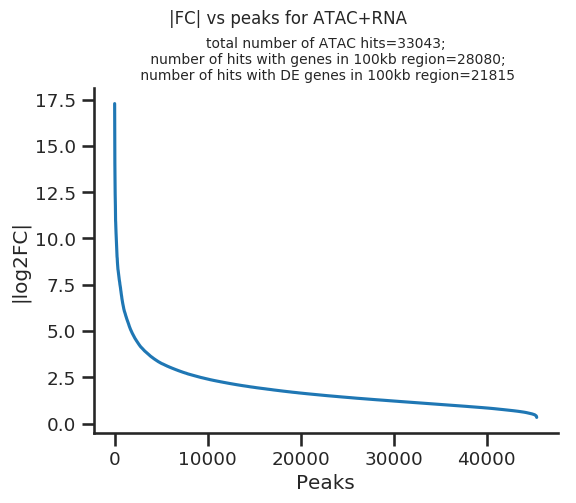

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms as mtransforms
%matplotlib inline

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.8)
plt.rcParams.update({'figure.figsize':(6,5), 'figure.dpi':100})

fig, ax = plt.subplots(1, 1)
plt.plot('|log2FC|', data=ATAC_RNA_100kb_genes)
ax.set_xlabel('Peaks')
ax.set_ylabel('|log2FC|')
plt.suptitle('|FC| vs peaks for ATAC+RNA', fontsize=12, y=1.01)
plt.title('total number of ATAC hits=33043;\n number of hits with genes in 100kb region=28080;\n number of hits with DE genes in 100kb region=21815', fontsize=10)

sns.despine(fig,ax)
plt.tight_layout()
plt.show()

In [150]:
ATAC_RNA_100kb_genes.head(15)

,chr,start,end,chr_start_end,ATAC_log2FoldChange,RNA_log2FoldChange,GeneName,|log2FC|
0,chr17,79738988,79739408,chr17_79738988_79739408,3.035686,14.246579,Cyp1b1,17.282265
1,chr13,56601255,56601818,chr13_56601255_56601818,4.370301,12.653597,Tgfbi,17.023898
2,chr3,37213303,37213537,chr3_37213303_37213537,2.948243,13.208127,Il21,16.156370
3,chr3,37287397,37287967,chr3_37287397_37287967,-2.920824,13.208127,Il21,16.128951
4,chr17,79755040,79755495,chr17_79755040_79755495,1.721831,14.246579,Cyp1b1,15.968410
5,chr1,20725668,20726173,chr1_20725668_20726173,4.867676,10.610688,Il17a,15.478364
6,chr17,79715094,79716102,chr17_79715094_79716102,1.162663,14.246579,Cyp1b1,15.409242
7,chr3,37156921,37157433,chr3_37156921_37157433,-2.060095,13.208127,Il21,15.268223
8,chr6,67483078,67483521,chr6_67483078_67483521,3.575967,11.632752,Il23r,15.208719
9,chr3,37231146,37231407,chr3_37231146_37231407,1.896756,13.208127,Il21,15.104883


In [79]:
import pandas as pd

KS151_Th17ASTARR_hits = pd.read_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/KS151_Th17ASTARR_hits.txt', sep='\t')
KS151_Th17ASTARR_hits = KS151_Th17ASTARR_hits[['chr','start','end','log2FoldChange','padj']]
KS151_Th17ASTARR_hits = KS151_Th17ASTARR_hits.rename(columns={'log2FoldChange':'ASTARR_log2FoldChange'})
KS151_Th17ASTARR_hits.to_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/KS151_Th17ASTARR_hits_corrected.bed', sep='\t', header=False, index=None)


In [80]:
%%bash 
module load bedtools2
cd /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data
bedtools intersect \
-a /data/reddylab/Revathy/dev/Keith/data/integrative/KS151_Th17ASTARR_hits_corrected.bed \
-b /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_RNA_100kb_genes.bed \
-wa \
-wb \
> /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_RNA_100kb_ASTARR_intersected.txt

***** WARNING: File /data/reddylab/Revathy/dev/Keith/data/integrative/KS151_Th17ASTARR_hits_corrected.bed has inconsistent naming convention for record:
GL456216.1	15775	17386	0.6504085605288249	1.4246487823061902e-10

***** WARNING: File /data/reddylab/Revathy/dev/Keith/data/integrative/KS151_Th17ASTARR_hits_corrected.bed has inconsistent naming convention for record:
GL456216.1	15775	17386	0.6504085605288249	1.4246487823061902e-10



In [81]:
%%bash
cat /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_RNA_100kb_ASTARR_intersected.txt \
| awk -vOFS='\t' '{print $1, $2<$7?$2:$7, $3<$8?$3:$8, $0}' > /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_RNA_100kb_ASTARR_intersected_filtered.txt


In [82]:
import pandas as pd

ATAC_RNA_100kb_ASTARR_intersected = pd.read_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_RNA_100kb_ASTARR_intersected_filtered.txt', sep='\t', 
                                                names=['chr','start','end',
                                                       'ASTARR_chr','ASTARR_start','ASTARR_end','ASTARR_log2FoldChange','ASTARR_padj',
                                                       'ATAC_chr','ATAC_start','ATAC_end','ATAC_chr_start_end','ATAC_log2FoldChange',
                                                       'RNA_log2FoldChange','GeneName','|log2FC|'])
#ATAC_RNA_100kb_ASTARR_intersected['chr_start_end'] = ATAC_RNA_100kb_ASTARR_intersected['chr'] + '_' + ATAC_RNA_100kb_ASTARR_intersected['start'].astype(str) + '_' + ATAC_RNA_100kb_ASTARR_intersected['end'].astype(str)
ATAC_RNA_100kb_ASTARR_intersected = ATAC_RNA_100kb_ASTARR_intersected[['chr','start','end','ATAC_log2FoldChange','RNA_log2FoldChange','GeneName','|log2FC|','ASTARR_log2FoldChange','ASTARR_padj']]
ATAC_RNA_100kb_ASTARR_intersected = ATAC_RNA_100kb_ASTARR_intersected.sort_values(by='|log2FC|', ascending=False).reset_index()
ATAC_RNA_100kb_ASTARR_intersected.drop(columns='index', inplace=True)
ATAC_RNA_100kb_ASTARR_intersected.head(5)

,chr,start,end,ATAC_log2FoldChange,RNA_log2FoldChange,GeneName,|log2FC|,ASTARR_log2FoldChange,ASTARR_padj
0,chr13,56601201,56601818,4.370301,12.653597,Tgfbi,17.023898,1.101679,6.320220e-31
1,chr3,37213303,37213537,2.948243,13.208127,Il21,16.156370,0.853785,9.211229e-09
2,chr17,79755008,79755331,1.721831,14.246579,Cyp1b1,15.968410,0.620197,7.622188e-04
3,chr17,79715094,79716097,1.162663,14.246579,Cyp1b1,15.409242,1.607470,1.131945e-57
4,chr3,37231146,37231407,1.896756,13.208127,Il21,15.104883,0.536181,2.668562e-03


In [83]:
# ATAC_RNA_100kb_ASTARR_intersected['norm_ASTARR_log2FC'] = ATAC_RNA_100kb_ASTARR_intersected['ASTARR_log2FoldChange']/((max(ATAC_RNA_100kb_ASTARR_intersected['ASTARR_log2FoldChange']))-(min(ATAC_RNA_100kb_ASTARR_intersected['ASTARR_log2FoldChange'])))
# ATAC_RNA_100kb_ASTARR_intersected['norm_ATAC_log2FC'] = ATAC_RNA_100kb_ASTARR_intersected['ATAC_log2FoldChange']/((max(ATAC_RNA_100kb_ASTARR_intersected['ATAC_log2FoldChange']))-(min(ATAC_RNA_100kb_ASTARR_intersected['ATAC_log2FoldChange'])))
# ATAC_RNA_100kb_ASTARR_intersected['norm_RNA_log2FC'] = ATAC_RNA_100kb_ASTARR_intersected['RNA_log2FoldChange']/((max(ATAC_RNA_100kb_ASTARR_intersected['RNA_log2FoldChange']))-(min(ATAC_RNA_100kb_ASTARR_intersected['RNA_log2FoldChange'])))

def quadrant_annotation(df):
    if ((df['ATAC_log2FoldChange'] < 0) and (df['RNA_log2FoldChange'] < 0)):
        return 'Dec.DA peaks; Downreg DE genes'
    if ((df['ATAC_log2FoldChange'] >= 0) and (df['RNA_log2FoldChange'] >= 0)):
        return 'Inc.DA peaks; Upreg DE genes'
    if ((df['ATAC_log2FoldChange'] < 0) and (df['RNA_log2FoldChange'] >= 0)):
        return 'Dec.DA peaks; Upreg DE genes'
    if ((df['ATAC_log2FoldChange'] >= 0) and (df['RNA_log2FoldChange'] < 0)):
        return 'Inc.DA peaks; Downreg DE genes'
    

ATAC_RNA_100kb_ASTARR_intersected['Quadrant_annot'] = ATAC_RNA_100kb_ASTARR_intersected.apply(quadrant_annotation, axis=1)
ATAC_RNA_100kb_ASTARR_intersected.to_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_RNA_ASTARR_100kb_annotated.bed', sep='\t', index=None, header=None)
ATAC_RNA_100kb_ASTARR_intersected.head(5)

,chr,start,end,ATAC_log2FoldChange,RNA_log2FoldChange,GeneName,|log2FC|,ASTARR_log2FoldChange,ASTARR_padj,Quadrant_annot
0,chr13,56601201,56601818,4.370301,12.653597,Tgfbi,17.023898,1.101679,6.320220e-31,Inc.DA peaks; Upreg DE genes
1,chr3,37213303,37213537,2.948243,13.208127,Il21,16.156370,0.853785,9.211229e-09,Inc.DA peaks; Upreg DE genes
2,chr17,79755008,79755331,1.721831,14.246579,Cyp1b1,15.968410,0.620197,7.622188e-04,Inc.DA peaks; Upreg DE genes
3,chr17,79715094,79716097,1.162663,14.246579,Cyp1b1,15.409242,1.607470,1.131945e-57,Inc.DA peaks; Upreg DE genes
4,chr3,37231146,37231407,1.896756,13.208127,Il21,15.104883,0.536181,2.668562e-03,Inc.DA peaks; Upreg DE genes


##### Find the ATAC peaks that do not intersect with the STARRseq hits and concatenate with the table which shows the ATAC peaks and the DE genes in the 100kb window of the ATAC peaks with the STARRseq hits

bedtools subtract - If an overlapping feature is found in B, the overlapping portion is removed from A and the remaining portion of A is reported. If a feature in B overlaps all of a feature in A, the A feature will not be reported. If a feature in B does not overlap a feature in A by at least the -f amount, the A feature will be reported in its entirety.

##### bedtools subtract [options] -a file_A -b file_B

In [85]:
%%bash 
module load bedtools2
cd /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data
bedtools subtract \
-a Th17_ATAC_RNA_100kb_genes.bed \
-b Th17_ATAC_RNA_ASTARR_100kb_annotated.bed \
> /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_RNA_not_in_ASTARR_100kb.txt

In [86]:
import pandas as pd

ATAC_RNA_not_in_ASTARR = pd.read_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_RNA_not_in_ASTARR_100kb.txt', sep='\t',
                                     names=['chr','start','end','chr_start_end','ATAC_log2FoldChange','RNA_log2FoldChange','GeneName','|log2FC|'])

ATAC_RNA_not_in_ASTARR.drop(columns='chr_start_end', inplace=False)
ATAC_RNA_not_in_ASTARR.sort_values(by='|log2FC|', ascending=False, inplace=False)
ATAC_RNA_not_in_ASTARR['Quadrant_annot'] = ATAC_RNA_not_in_ASTARR.apply(quadrant_annotation, axis=1)
ATAC_RNA_not_in_ASTARR = ATAC_RNA_not_in_ASTARR.drop(columns = 'chr_start_end')
ATAC_RNA_not_in_ASTARR.head(5)

,chr,start,end,ATAC_log2FoldChange,RNA_log2FoldChange,GeneName,|log2FC|,Quadrant_annot
0,chr17,79738988,79739408,3.035686,14.246579,Cyp1b1,17.282265,Inc.DA peaks; Upreg DE genes
1,chr3,37287397,37287967,-2.920824,13.208127,Il21,16.128951,Dec.DA peaks; Upreg DE genes
2,chr17,79755331,79755495,1.721831,14.246579,Cyp1b1,15.968410,Inc.DA peaks; Upreg DE genes
3,chr1,20725668,20726173,4.867676,10.610688,Il17a,15.478364,Inc.DA peaks; Upreg DE genes
4,chr17,79716097,79716102,1.162663,14.246579,Cyp1b1,15.409242,Inc.DA peaks; Upreg DE genes


In [87]:
daATAC_deRNA_ASTARR = pd.concat([ATAC_RNA_100kb_ASTARR_intersected,ATAC_RNA_not_in_ASTARR], ignore_index=True, sort=False)
daATAC_deRNA_ASTARR.to_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_daATAC_deRNA_applicableASTARR_with_pvalue.txt', sep='\t')

In [88]:
sig_genes = ['Maf', 'Il17a', 'Rorc', 'Stat3', 'Stat5', 'Batf', 'Irf4', 'Runx1', 'Il21r', 'Tbx21', 'Foxp3']
ATAC_RNA_100kb_ASTARR_intersected_spGenes = ATAC_RNA_100kb_ASTARR_intersected[ATAC_RNA_100kb_ASTARR_intersected['GeneName'].isin(sig_genes)]

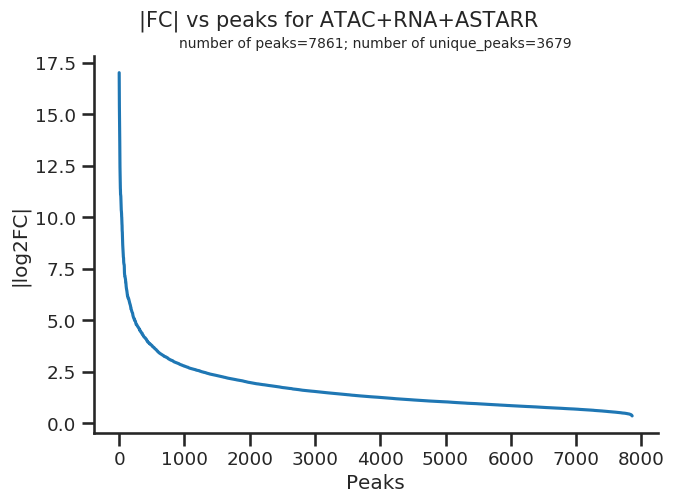

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms as mtransforms
%matplotlib inline

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.8)
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

fig, ax = plt.subplots(1, 1)
plt.plot('|log2FC|', data=ATAC_RNA_100kb_ASTARR_intersected)
ax.set_xlabel('Peaks')
ax.set_ylabel('|log2FC|')
plt.suptitle('|FC| vs peaks for ATAC+RNA+ASTARR', fontsize=15, y=1.01)
plt.title('number of peaks=7861; number of unique_peaks=3679', fontsize=10)

sns.despine(fig,ax)
plt.tight_layout()
plt.show()

In [127]:
print(min(ATAC_RNA_100kb_ASTARR_intersected.norm_RNA_log2FC))
print(max(ATAC_RNA_100kb_ASTARR_intersected.norm_RNA_log2FC))

-0.4124055754824121
0.5875944245175878


min_ATAC = -0.3
max_ATAC = 0.6
min_ASTARR = -0.6
max_ASTARR = 0.3
min_RNA = -0.4
max_RNA = 0.5

/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/seaborn/matrix.py:626: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


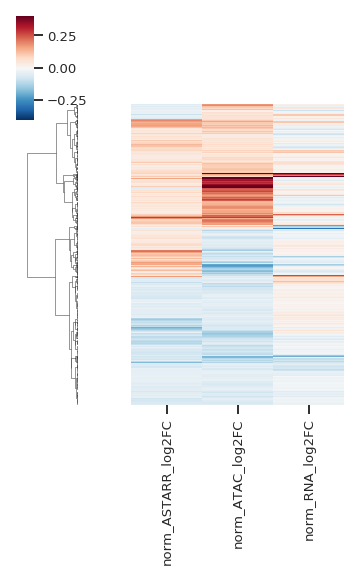

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms as mtransforms
%matplotlib inline

ATAC_RNA_100kb_ASTARR_intersected['norm_ASTARR_log2FC'] = ATAC_RNA_100kb_ASTARR_intersected['ASTARR_log2FoldChange']/((max(ATAC_RNA_100kb_ASTARR_intersected['ASTARR_log2FoldChange']))-(min(ATAC_RNA_100kb_ASTARR_intersected['ASTARR_log2FoldChange'])))
ATAC_RNA_100kb_ASTARR_intersected['norm_ATAC_log2FC'] = ATAC_RNA_100kb_ASTARR_intersected['ATAC_log2FoldChange']/((max(ATAC_RNA_100kb_ASTARR_intersected['ATAC_log2FoldChange']))-(min(ATAC_RNA_100kb_ASTARR_intersected['ATAC_log2FoldChange'])))
ATAC_RNA_100kb_ASTARR_intersected['norm_RNA_log2FC'] = ATAC_RNA_100kb_ASTARR_intersected['RNA_log2FoldChange']/((max(ATAC_RNA_100kb_ASTARR_intersected['RNA_log2FoldChange']))-(min(ATAC_RNA_100kb_ASTARR_intersected['RNA_log2FoldChange'])))


sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.8)
#plt.rcParams.update({'figure.figsize':(5,8), 'figure.dpi':100})

g = sns.clustermap(ATAC_RNA_100kb_ASTARR_intersected.loc[:, ['norm_ASTARR_log2FC','norm_ATAC_log2FC','norm_RNA_log2FC']],
               vmin=-0.4,
               vmax=0.4,
               cmap='RdBu_r',
               method='ward',
               figsize=[5,8],
               col_cluster=False,
               yticklabels='')

plt.savefig('/data/reddylab/Revathy/dev/Keith/data/integrative/plots/Th17_ATAC_RNA_ASTARR_100kb_heatmap.pdf')

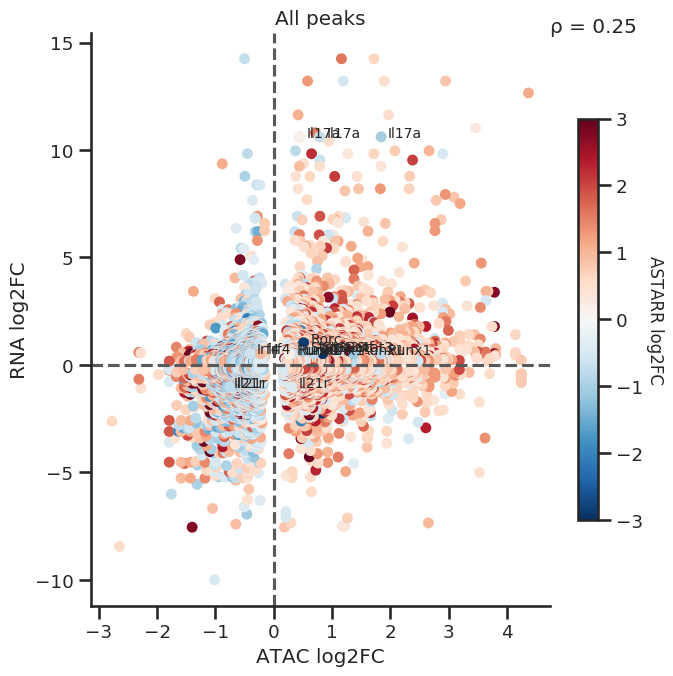

In [90]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
import numpy as np
%matplotlib inline

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt 

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1" # u'\u03C1'
    ax.annotate('%s = %.2f' % (rho, r), xy=(1, 1), xycoords=ax.transAxes)
    
#plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.8)
plt.rcParams.update({'figure.figsize':(7,7), 'figure.dpi':100})

fig, ax = plt.subplots(1, 1)

points = ax.scatter(
    ATAC_RNA_100kb_ASTARR_intersected['ATAC_log2FoldChange'], 
    ATAC_RNA_100kb_ASTARR_intersected['RNA_log2FoldChange'],
    c=ATAC_RNA_100kb_ASTARR_intersected['ASTARR_log2FoldChange'],
    cmap='RdBu_r', marker='o', s=40)

for x, y, t in zip(
    ATAC_RNA_100kb_ASTARR_intersected_spGenes['ATAC_log2FoldChange'],
    ATAC_RNA_100kb_ASTARR_intersected_spGenes['RNA_log2FoldChange'], 
    ATAC_RNA_100kb_ASTARR_intersected_spGenes['GeneName']):
    ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=10)

ax.scatter(
    ATAC_RNA_100kb_ASTARR_intersected_spGenes['ATAC_log2FoldChange'], 
    ATAC_RNA_100kb_ASTARR_intersected_spGenes['RNA_log2FoldChange'],
    c=ATAC_RNA_100kb_ASTARR_intersected_spGenes['ASTARR_log2FoldChange'],
    cmap='RdBu_r', marker='o', s=40)

corrfunc(
    ATAC_RNA_100kb_ASTARR_intersected['ATAC_log2FoldChange'], 
    ATAC_RNA_100kb_ASTARR_intersected['RNA_log2FoldChange'],
    ax=ax, method='spearman')

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color='#5A5959', linestyle='--')
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color='#5A5959', linestyle='--')
ax.set_xlabel('ATAC log2FC')
ax.set_ylabel('RNA log2FC')
ax.set_title('All peaks')

cbar = fig.colorbar(points, shrink=0.7, ax=ax)
cbar.set_label('ASTARR log2FC', rotation=270, fontsize=12, labelpad=15)
cbar.mappable.set_clim(-3,3)

sns.despine(fig,ax)
plt.tight_layout()
plt.show()

### Nearest gene analysis for STARRseq data

* For the set of all STARRseq peaks, get the DE genes in the 100kb region. 
* Get genomic annotations for each peak using **bedtools closest**; ignore the closest genes
* Plot co-ordinate plots with panels for TSS(distance=0), promoter(>1kb and <3kb), distal(>=3kb)


* Intersect this with the ATAC peaks add the ATAC log2FC and ATAC padj.value for those intersecting peaks and for others also
* Calculate the |log2FC| = |ASTARR_log2FC| + |RNA_log2FC|
* Plot the lineplot between |log2FC| and the peaks


In [25]:
%%bash 
module load bedtools2
bedtools window -a /data/reddylab/Revathy/dev/Keith/data/integrative/KS151_Th17ASTARR_hits_corrected.bed \
-b /data/reddylab/Revathy/dev/Keith/data/gencode.vM19.basic.annotation.TSS.bed \
-w 100000 > /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_100kb_genes.txt

In [1]:
!wc -l /data/reddylab/Revathy/collabs/Keith/data/integrative/tmp_data/Th17_ASTARR_100kb_genes.txt

32990 /data/reddylab/Revathy/collabs/Keith/data/integrative/tmp_data/Th17_ASTARR_100kb_genes.txt


In [92]:
import pandas as pd

ASTARR_hits_100_genes = pd.read_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_100kb_genes.txt', sep='\t',
                                    names = ['chr','start','end','ASTARR_log2FoldChange','ASTARR_padj',
                                             'gene_chr','gene_start','gene_end','ENSEMBL_ID','dot','strand','GeneName','GeneFunc'])
ASTARR_hits_100_genes = ASTARR_hits_100_genes[['chr','start','end','ASTARR_log2FoldChange','GeneName']]
ASTARR_hits_100_genes['chr_start_end'] = ASTARR_hits_100_genes['chr']+'_'+ASTARR_hits_100_genes['start'].astype('str')+'_'+ASTARR_hits_100_genes['end'].astype('str')

len(ASTARR_hits_100_genes.chr_start_end.unique())

8277

#### Out of the 9324 peaks in STARRseq, there are 8277 peaks with genes in the 100kb region and 6755 peaks with DE genes in the 100kb. When intersected with the ATACseq peaks, there are 3675 peaks common between ATACseq and ASTARRseq with DE genes in the 100kb region of ASTARR hits

In [93]:
ASTARR_RNA_100kb_genes = ASTARR_hits_100_genes.merge(RNA_genes, on='GeneName', how='inner')
ASTARR_RNA_100kb_genes = ASTARR_RNA_100kb_genes.rename(columns={'log2FoldChange':'RNA_log2FoldChange'})
ASTARR_RNA_100kb_genes[['chr','start','end']] = ASTARR_RNA_100kb_genes.chr_start_end.str.split("_",expand=True)
ASTARR_RNA_100kb_genes = ASTARR_RNA_100kb_genes[['chr','start','end','chr_start_end','ASTARR_log2FoldChange','RNA_log2FoldChange','GeneName']]
ASTARR_RNA_100kb_genes.sort_values(by='chr_start_end')
ASTARR_RNA_100kb_genes['|log2FC|'] = np.abs(ASTARR_RNA_100kb_genes['ASTARR_log2FoldChange']) + np.abs(ASTARR_RNA_100kb_genes['RNA_log2FoldChange'])
ASTARR_RNA_100kb_genes = ASTARR_RNA_100kb_genes.sort_values(by='|log2FC|', ascending=False)
ASTARR_RNA_100kb_genes = ASTARR_RNA_100kb_genes.reset_index()
ASTARR_RNA_100kb_genes = ASTARR_RNA_100kb_genes.drop(columns='index')
ASTARR_RNA_100kb_genes.to_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_100kb_genes.bed', sep='\t', index=False, header=None)
ASTARR_RNA_100kb_genes.to_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_100kb_genes.txt', sep='\t', index=False)


In [94]:
!head /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_100kb_genes.bed

chr17	79715577	79716097	chr17_79715577_79716097	1.60746957018745	14.2465793662196	Cyp1b1	15.854048936407048
chr17	79614986	79615534	chr17_79614986_79615534	-0.7391187607775479	14.2465793662196	Cyp1b1	14.985698126997146
chr17	79755008	79755331	chr17_79755008_79755331	0.620197098308082	14.2465793662196	Cyp1b1	14.866776464527682
chr3	37173169	37173736	chr3_37173169_37173736	1.31007698880974	13.2081273765604	Il21	14.51820436537014
chr3	37213347	37213655	chr3_37213347_37213655	0.853785401349287	13.2081273765604	Il21	14.061912777909686
chr13	56601201	56601855	chr13_56601201_56601855	1.10167859069687	12.6535968676007	Tgfbi	13.75527545829757
chr3	37231354	37231589	chr3_37231354_37231589	0.536181421304778	13.2081273765604	Il21	13.744308797865179
chr3	37219202	37219529	chr3_37219202_37219529	-0.524473116197738	13.2081273765604	Il21	13.732600492758138
chr3	37313407	37313912	chr3_37313407_37313912	0.503811128091176	13.2081273765604	Il21	13.711938504651576
chr13	56522190	56522726	chr13_56522190_565

In [104]:
ASTARR_RNA_100kb_genes.head(15)

,chr,start,end,chr_start_end,ASTARR_log2FoldChange,RNA_log2FoldChange,GeneName,|log2FC|
0,chr17,79715577,79716097,chr17_79715577_79716097,1.607470,14.246579,Cyp1b1,15.854049
1,chr17,79614986,79615534,chr17_79614986_79615534,-0.739119,14.246579,Cyp1b1,14.985698
2,chr17,79755008,79755331,chr17_79755008_79755331,0.620197,14.246579,Cyp1b1,14.866776
3,chr3,37173169,37173736,chr3_37173169_37173736,1.310077,13.208127,Il21,14.518204
4,chr3,37213347,37213655,chr3_37213347_37213655,0.853785,13.208127,Il21,14.061913
5,chr13,56601201,56601855,chr13_56601201_56601855,1.101679,12.653597,Tgfbi,13.755275
6,chr3,37231354,37231589,chr3_37231354_37231589,0.536181,13.208127,Il21,13.744309
7,chr3,37219202,37219529,chr3_37219202_37219529,-0.524473,13.208127,Il21,13.732600
8,chr3,37313407,37313912,chr3_37313407_37313912,0.503811,13.208127,Il21,13.711939
9,chr13,56522190,56522726,chr13_56522190_56522726,-0.501968,12.653597,Tgfbi,13.155565


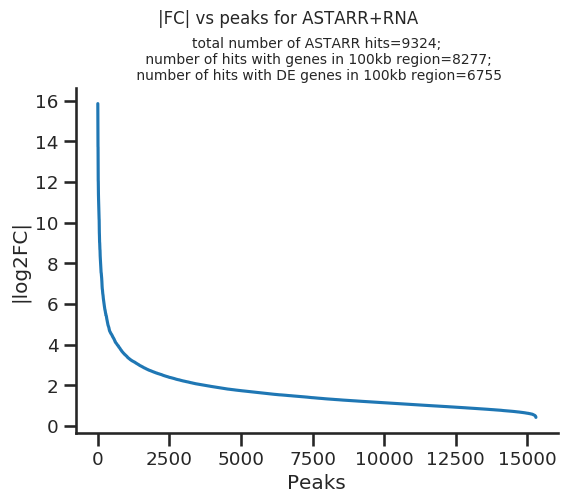

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms as mtransforms
%matplotlib inline

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.8)
plt.rcParams.update({'figure.figsize':(6,5), 'figure.dpi':100})

fig, ax = plt.subplots(1, 1)
plt.plot('|log2FC|', data=ASTARR_RNA_100kb_genes)
ax.set_xlabel('Peaks')
ax.set_ylabel('|log2FC|')
plt.suptitle('|FC| vs peaks for ASTARR+RNA', fontsize=12, y=1.01)
plt.title('total number of ASTARR hits=9324;\n number of hits with genes in 100kb region=8277;\n number of hits with DE genes in 100kb region=6755', fontsize=10)

sns.despine(fig,ax)
plt.tight_layout()
plt.show()

In [97]:
%%bash
cd /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data
sbatch -pnew,all \
    --cpus-per-task 1 \
    --mem 8G \
    -o /data/reddylab/Revathy/dev/Keith/data/integrative/logs/Th17_ASTARR_RNA_100kb_genes_annotation.out \
    <<'EOF'
#!/bin/bash
SAMPLE="Th17_ASTARR_RNA_100kb_genes.txt"

tail -n+2 ${SAMPLE} \
| cut -f1,2,3 \
| awk -vOFS="\t" '{print $1,$2,$3,$1"_"$2"_"$3}' \
| sort -k1,1 -k2,2n \
| bedtools closest \
    -nonamecheck \
    -D a \
    -a - \
    -b /data/reddylab/Revathy/dev/Keith/data/gencode.vM19.basic.annotation.TSS.bed \
| awk -vOFS="\t" \
    '{if(last==$4){genes=$11","genes;}else{if(genes){print peak, genes, distance}peak=$4; genes=$11; distance=$13; last=peak}}END{if(last==$4){genes=$11","genes;print peak, genes, distance}}' \
> ${SAMPLE/.txt/.closest_gene.txt}

EOF

Submitted batch job 25377008


In [2]:
!head /data/reddylab/Revathy/collabs/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_100kb_genes.txt

chr	start	end	chr_start_end	ASTARR_log2FoldChange	RNA_log2FoldChange	GeneName	|log2FC|
chr17	79715577	79716097	chr17_79715577_79716097	1.60746957018745	14.2465793662196	Cyp1b1	15.854048936407048
chr17	79614986	79615534	chr17_79614986_79615534	-0.7391187607775479	14.2465793662196	Cyp1b1	14.985698126997146
chr17	79755008	79755331	chr17_79755008_79755331	0.620197098308082	14.2465793662196	Cyp1b1	14.866776464527682
chr3	37173169	37173736	chr3_37173169_37173736	1.31007698880974	13.2081273765604	Il21	14.51820436537014
chr3	37213347	37213655	chr3_37213347_37213655	0.853785401349287	13.2081273765604	Il21	14.061912777909686
chr13	56601201	56601855	chr13_56601201_56601855	1.10167859069687	12.6535968676007	Tgfbi	13.75527545829757
chr3	37231354	37231589	chr3_37231354_37231589	0.536181421304778	13.2081273765604	Il21	13.744308797865179
chr3	37219202	37219529	chr3_37219202_37219529	-0.524473116197738	13.2081273765604	Il21	13.732600492758138
chr3	37313407	37313912	chr3_37313407_37313912	0.503811128091

In [98]:
ASTARR_RNA_100kb_with_genes = pd.read_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_100kb_genes.closest_gene.txt', sep='\t', names=['chr_start_end','genes','distance'])
ASTARRR_RNA_100kb_genes_annot = ASTARR_RNA_100kb_genes.merge(ASTARR_RNA_100kb_with_genes, on='chr_start_end', how='inner')
ASTARRR_RNA_100kb_genes_annot = ASTARRR_RNA_100kb_genes_annot[['chr','start','end','chr_start_end','ASTARR_log2FoldChange','RNA_log2FoldChange','GeneName','|log2FC|','distance']]
ASTARRR_RNA_100kb_genes_annot.to_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_100kb_genes_dist_annotated.bed', sep='\t', index=None, header=None)

sig_genes = ['Maf', 'Il17a', 'Rorc', 'Stat3', 'Stat5', 'Batf', 'Irf4', 'Runx1', 'Il21r', 'Tbx21', 'Foxp3']
ASTARRR_RNA_100kb_genes_annot_spGenes = ASTARRR_RNA_100kb_genes_annot[ASTARRR_RNA_100kb_genes_annot['GeneName'].isin(sig_genes)]
ASTARRR_RNA_100kb_genes_annot_spGenes


,chr,start,end,chr_start_end,ASTARR_log2FoldChange,RNA_log2FoldChange,GeneName,|log2FC|,distance
32,chr1,20693764,20693980,chr1_20693764_20693980,1.435845,10.610688,Il17a,12.046533,36924
36,chr1,20730780,20731089,chr1_20730780_20731089,1.130062,10.610688,Il17a,11.740751,0
42,chr1,20740539,20740902,chr1_20740539_20740902,0.918622,10.610688,Il17a,11.529311,-9636
45,chr1,20634920,20635229,chr1_20634920_20635229,0.766835,10.610688,Il17a,11.377524,-16857
47,chr1,20766672,20767135,chr1_20766672_20767135,0.662654,10.610688,Il17a,11.273342,17135
54,chr1,20759615,20760094,chr1_20759615_20760094,0.528834,10.610688,Il17a,11.139523,24176
59,chr1,20791580,20791998,chr1_20791580_20791998,0.390202,10.610688,Il17a,11.000890,-7311
152,chr8,115770867,115771297,chr8_115770867_115771297,0.653809,8.005572,Maf,8.659381,-63074
156,chr8,115625049,115625396,chr8_115625049_115625396,0.522435,8.005572,Maf,8.528007,82398
372,chr11,97112798,97113049,chr11_97112798_97113049,0.751321,2.670070,Tbx21,3.421390,2282


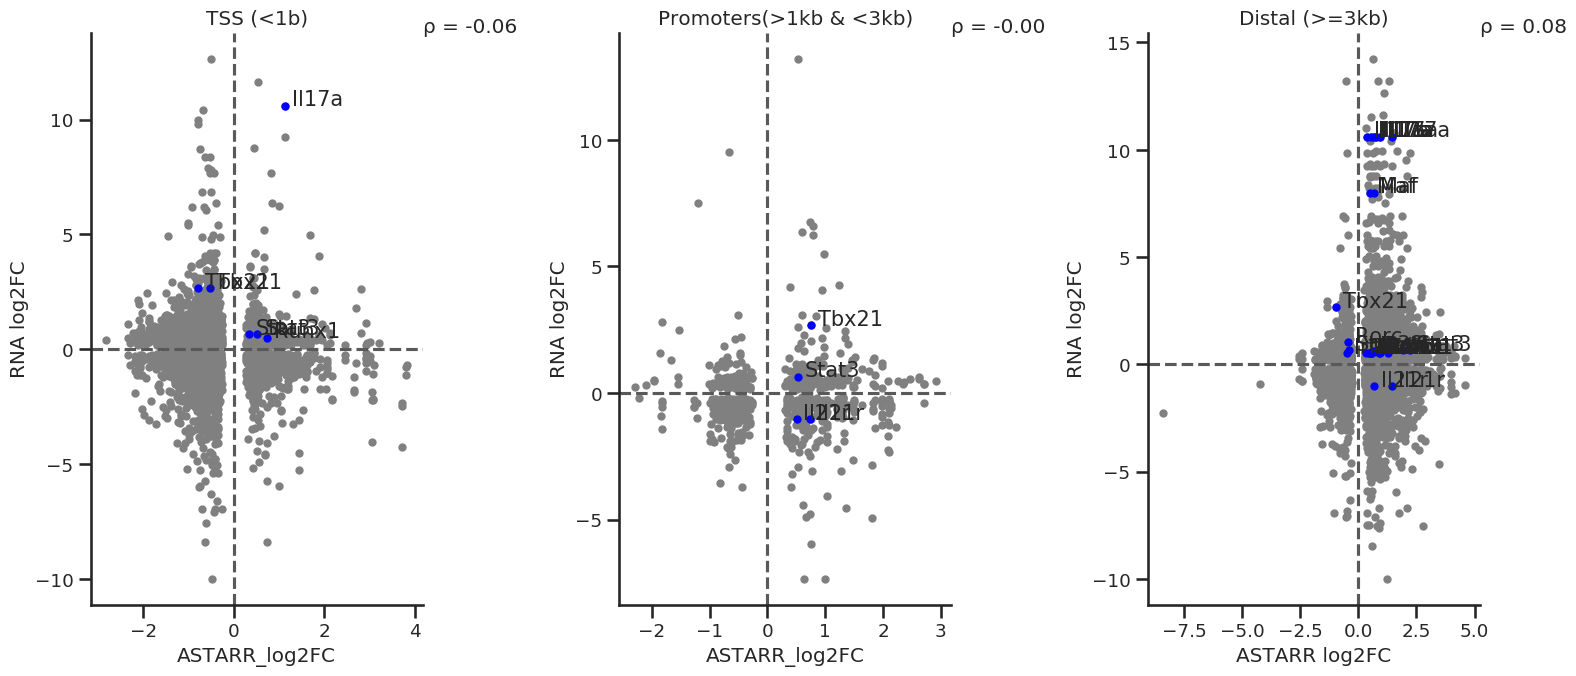

In [105]:
### Scatterplot for TSS(1b), promoter(>1kb&<3kb), distal(>=3kb) and all regions for ATACseq vs ASTARRseq

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
import numpy as np
%matplotlib inline

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt 

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1" # u'\u03C1'
    ax.annotate('%s = %.2f' % (rho, r), xy=(1, 1), xycoords=ax.transAxes)
    
#plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.8)
plt.rcParams.update({'figure.figsize':(16,7), 'figure.dpi':100})

fig, ax = plt.subplots(1, 3)

ax1 = ax.flatten()[0]
points = ax1.scatter(
    ASTARRR_RNA_100kb_genes_annot.loc[np.abs(ASTARRR_RNA_100kb_genes_annot.distance)<1, 'ASTARR_log2FoldChange'], 
    ASTARRR_RNA_100kb_genes_annot.loc[np.abs(ASTARRR_RNA_100kb_genes_annot.distance)<1, 'RNA_log2FoldChange'],
    color='gray', marker='o', s=20, label='All hits')

for x, y, t in zip(
    ASTARRR_RNA_100kb_genes_annot_spGenes.loc[np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)<1, 'ASTARR_log2FoldChange'],
    ASTARRR_RNA_100kb_genes_annot_spGenes.loc[np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)<1, 'RNA_log2FoldChange'], 
    ASTARRR_RNA_100kb_genes_annot_spGenes.loc[np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)<1, 'GeneName']) :
    ax1.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)

ax1.scatter(ASTARRR_RNA_100kb_genes_annot_spGenes.loc[np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)<1, 'ASTARR_log2FoldChange'], 
    ASTARRR_RNA_100kb_genes_annot_spGenes.loc[np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)<1, 'RNA_log2FoldChange'], marker='o', s=20, color='blue', label='Genes of Interest')

corrfunc(
    ASTARRR_RNA_100kb_genes_annot.loc[np.abs(ASTARRR_RNA_100kb_genes_annot.distance)<1, 'ASTARR_log2FoldChange'], 
    ASTARRR_RNA_100kb_genes_annot.loc[np.abs(ASTARRR_RNA_100kb_genes_annot.distance)<1, 'RNA_log2FoldChange'],
    ax=ax1, method='spearman')

ax1.set_xlim(ax1.get_xlim())
ax1.set_ylim(ax1.get_ylim())
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color='#5A5959', linestyle='--')
ax1.hlines(0, ax1.get_xlim()[0], ax1.get_xlim()[1], color='#5A5959', linestyle='--')
ax1.set_xlabel('ASTARR_log2FC')
ax1.set_ylabel('RNA log2FC')
ax1.set_title('TSS (<1b)')

ax2 = ax.flatten()[1]
points = ax2.scatter(
    ASTARRR_RNA_100kb_genes_annot.loc[(np.abs(ASTARRR_RNA_100kb_genes_annot.distance)>1000)&(np.abs(ASTARRR_RNA_100kb_genes_annot.distance)<3000), 'ASTARR_log2FoldChange'], 
    ASTARRR_RNA_100kb_genes_annot.loc[(np.abs(ASTARRR_RNA_100kb_genes_annot.distance)>1000)&(np.abs(ASTARRR_RNA_100kb_genes_annot.distance)<3000), 'RNA_log2FoldChange'],
    color='gray', marker='o', s=20, label='All hits')

for x, y, t in zip(
    ASTARRR_RNA_100kb_genes_annot_spGenes.loc[(np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)>1000)&(np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)<3000), 'ASTARR_log2FoldChange'],
    ASTARRR_RNA_100kb_genes_annot_spGenes.loc[(np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)>1000)&(np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)<3000), 'RNA_log2FoldChange'], 
    ASTARRR_RNA_100kb_genes_annot_spGenes.loc[(np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)>1000)&(np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)<3000), 'GeneName']) :
    ax2.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)

ax2.scatter(ASTARRR_RNA_100kb_genes_annot_spGenes.loc[(np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)>1000)&(np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)<3000), 'ASTARR_log2FoldChange'], 
    ASTARRR_RNA_100kb_genes_annot_spGenes.loc[(np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)>1000)&(np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)<3000), 'RNA_log2FoldChange'], marker='o', s=20, color='blue', label='Genes of Interest')

corrfunc(
    ASTARRR_RNA_100kb_genes_annot.loc[(np.abs(ASTARRR_RNA_100kb_genes_annot.distance)>1000)&(np.abs(ASTARRR_RNA_100kb_genes_annot.distance)<3000), 'ASTARR_log2FoldChange'], 
    ASTARRR_RNA_100kb_genes_annot.loc[(np.abs(ASTARRR_RNA_100kb_genes_annot.distance)>1000)&(np.abs(ASTARRR_RNA_100kb_genes_annot.distance)<3000), 'RNA_log2FoldChange'],
    ax=ax2, method='spearman')

ax2.set_xlim(ax2.get_xlim())
ax2.set_ylim(ax2.get_ylim())
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color='#5A5959', linestyle='--')
ax2.hlines(0, ax2.get_xlim()[0], ax2.get_xlim()[1], color='#5A5959', linestyle='--')
ax2.set_xlabel('ASTARR_log2FC')
ax2.set_ylabel('RNA log2FC')
ax2.set_title('Promoters(>1kb & <3kb)')

ax3 = ax.flatten()[2]
points = ax3.scatter(
    ASTARRR_RNA_100kb_genes_annot.loc[np.abs(ASTARRR_RNA_100kb_genes_annot.distance)>=3000, 'ASTARR_log2FoldChange'], 
    ASTARRR_RNA_100kb_genes_annot.loc[np.abs(ASTARRR_RNA_100kb_genes_annot.distance)>=3000, 'RNA_log2FoldChange'],
    color='gray', marker='o', s=20, label='All hits')

for x, y, t in zip(
    ASTARRR_RNA_100kb_genes_annot_spGenes.loc[np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)>=3000, 'ASTARR_log2FoldChange'],
    ASTARRR_RNA_100kb_genes_annot_spGenes.loc[np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)>=3000, 'RNA_log2FoldChange'], 
    ASTARRR_RNA_100kb_genes_annot_spGenes.loc[np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)>=3000, 'GeneName']) :
    ax3.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)
    
ax3.scatter(ASTARRR_RNA_100kb_genes_annot_spGenes.loc[np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)>=3000, 'ASTARR_log2FoldChange'], 
    ASTARRR_RNA_100kb_genes_annot_spGenes.loc[np.abs(ASTARRR_RNA_100kb_genes_annot_spGenes.distance)>=3000, 'RNA_log2FoldChange'], marker='o', s=20, color='blue', label='Genes of Interest')
corrfunc(
    ASTARRR_RNA_100kb_genes_annot.loc[np.abs(ASTARRR_RNA_100kb_genes_annot.distance)>=3000, 'ASTARR_log2FoldChange'], 
    ASTARRR_RNA_100kb_genes_annot.loc[np.abs(ASTARRR_RNA_100kb_genes_annot.distance)>=3000, 'RNA_log2FoldChange'],
    ax=ax3, method='spearman')

ax3.set_xlim(ax3.get_xlim())
ax3.set_ylim(ax3.get_ylim())
ax3.vlines(0, ax3.get_ylim()[0], ax3.get_ylim()[1], color='#5A5959', linestyle='--')
ax3.hlines(0, ax3.get_xlim()[0], ax3.get_xlim()[1], color='#5A5959', linestyle='--')
ax3.set_xlabel('ASTARR log2FC')
ax3.set_ylabel('RNA log2FC')
ax3.set_title('Distal (>=3kb)')


# ax3 = ax.flatten()[2]
# points = ax3.scatter(
#     top_ATAC_not_ASTARR_with_genes_RNA.loc[:, 'ATAC_log2FoldChange'], 
#     top_ATAC_not_ASTARR_with_genes_RNA.loc[:, 'RNA_log2FoldChange'],
#     color='gray', marker='o', s=20, label='All hits')

# for x, y, t in zip(
#     top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[:, 'ATAC_log2FoldChange'],
#     top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[:, 'RNA_log2FoldChange'], 
#     top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[:, 'GeneName']) :
#     ax3.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)
    
# ax3.scatter(top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[:, 'ATAC_log2FoldChange'], 
#     top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[:, 'RNA_log2FoldChange'], marker='o', s=20, color='blue', label='Genes of Interest')
# corrfunc(
#     top_ATAC_not_ASTARR_with_genes_RNA.loc[:, 'ATAC_log2FoldChange'], 
#     top_ATAC_not_ASTARR_with_genes_RNA.loc[:, 'RNA_log2FoldChange'],
#     ax=ax3, method='spearman')

# ax3.set_xlim(ax3.get_xlim())
# ax3.set_ylim(ax3.get_ylim())
# ax3.vlines(0, ax3.get_ylim()[0], ax3.get_ylim()[1], color='#5A5959', linestyle='--')
# ax3.hlines(0, ax3.get_xlim()[0], ax3.get_xlim()[1], color='#5A5959', linestyle='--')
# ax3.set_xlabel('ATAC log2FC')
# ax3.set_ylabel('RNA log2FC')
# ax3.set_title('All Peaks')

# cbar = fig.colorbar(points)
# cbar.set_label('abs. distance to closest TSS', rotation=270)

sns.despine(fig,ax)
plt.tight_layout()
plt.savefig('/data/reddylab/Revathy/dev/Keith/data/integrative/plots/Th17_ASTARR_RNA_TSS_promoter_distal_scatterplot.pdf')
plt.show()

In [100]:
ATAC_hits = ATAC_hits.rename(columns={'log2FoldChange':'ATAC_log2FoldChange'})
ATAC_hits = ATAC_hits[['chr','start','end','ATAC_log2FoldChange','padj']]
ATAC_hits.to_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_hits_corrected.bed', sep='\t', index=None, header=None)


In [37]:
%%bash 
module load bedtools2
cd /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data
bedtools intersect \
-a /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_hits_corrected.bed \
-b /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_100kb_genes_dist_annotated.bed \
-wa \
-wb \
> /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_100kb_ATAC_intersected.txt

***** WARNING: File /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_hits_corrected.bed has inconsistent naming convention for record:
JH584304.1	58860	61077	-0.6417921415048189	1.00153216726169e-09

***** WARNING: File /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ATAC_hits_corrected.bed has inconsistent naming convention for record:
JH584304.1	58860	61077	-0.6417921415048189	1.00153216726169e-09



In [38]:
!wc -l /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_100kb_ATAC_intersected.txt

7835 /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_100kb_ATAC_intersected.txt


In [39]:
!head /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_100kb_ATAC_intersected.txt 

chr17	24922249	24923127	4.24763116641612	1.0475251053793292e-253	chr17	24922267	24923020	chr17_24922267_24923020	0.7932637916832049	-0.822810356539693	Eme2	1.616074148222898	13957
chr17	24922249	24923127	4.24763116641612	1.0475251053793292e-253	chr17	24922267	24923020	chr17_24922267_24923020	0.7932637916832049	-0.7246324820322969	Fahd1	1.5178962737155017	13957
chr17	24922249	24923127	4.24763116641612	1.0475251053793292e-253	chr17	24922267	24923020	chr17_24922267_24923020	0.7932637916832049	-0.589345234421398	Mapk8ip3	1.382609026104603	13957
chr17	24922249	24923127	4.24763116641612	1.0475251053793292e-253	chr17	24922267	24923020	chr17_24922267_24923020	0.7932637916832049	-0.549224356729958	Hagh	1.342488148413163	13957
chr17	24922249	24923127	4.24763116641612	1.0475251053793292e-253	chr17	24922267	24923020	chr17_24922267_24923020	0.7932637916832049	-0.420449201514955	Mrps34	1.2137129931981598	13957
chr17	24922249	24923127	4.24763116641612	1.0475251053793292e-253	chr17	24922267	24923020	c

In [40]:
%%bash
cat /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_100kb_ATAC_intersected.txt \
| awk -vOFS='\t' '{print $1, $2<$7?$2:$7, $3<$8?$3:$8, $0}' > /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_100kb_ATAC_intersected_filtered.txt


In [101]:
import pandas as pd

ASTARR_RNA_100kb_ATAC_intersected = pd.read_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_100kb_ATAC_intersected_filtered.txt', sep='\t', 
                                                names=['chr','start','end',
                                                       'ATAC_chr','ATAC_start','ATAC_end','ATAC_log2FoldChange','ATAC_padj',
                                                       'ASTARR_chr','ASTARR_start','ASTARR_end','ASTARR_chr_start_end','ASTARR_log2FoldChange',
                                                       'RNA_log2FoldChange','GeneName','|log2FC|','distance'])
ASTARR_RNA_100kb_ATAC_intersected['chr_start_end'] = ASTARR_RNA_100kb_ATAC_intersected['chr'] + '_' + ASTARR_RNA_100kb_ATAC_intersected['start'].astype(str) + '_' + ASTARR_RNA_100kb_ATAC_intersected['end'].astype(str)
ASTARR_RNA_100kb_ATAC_intersected = ASTARR_RNA_100kb_ATAC_intersected[['chr','start','end','chr_start_end','ASTARR_log2FoldChange','RNA_log2FoldChange','GeneName','|log2FC|','distance','ATAC_log2FoldChange','ATAC_padj']]
ASTARR_RNA_100kb_ATAC_intersected = ASTARR_RNA_100kb_ATAC_intersected.sort_values(by='|log2FC|', ascending=False).reset_index()
ASTARR_RNA_100kb_ATAC_intersected.drop(columns='index', inplace=True)

sig_genes = ['Maf', 'Il17a', 'Rorc', 'Stat3', 'Stat5', 'Batf', 'Irf4', 'Runx1', 'Il21r', 'Tbx21', 'Foxp3']
ASTARR_RNA_100kb_ATAC_intersected_spGenes = ASTARR_RNA_100kb_ATAC_intersected[ASTARR_RNA_100kb_ATAC_intersected['GeneName'].isin(sig_genes)]


In [102]:
max(ASTARR_RNA_100kb_ATAC_intersected.ATAC_log2FoldChange)

4.37030113192486

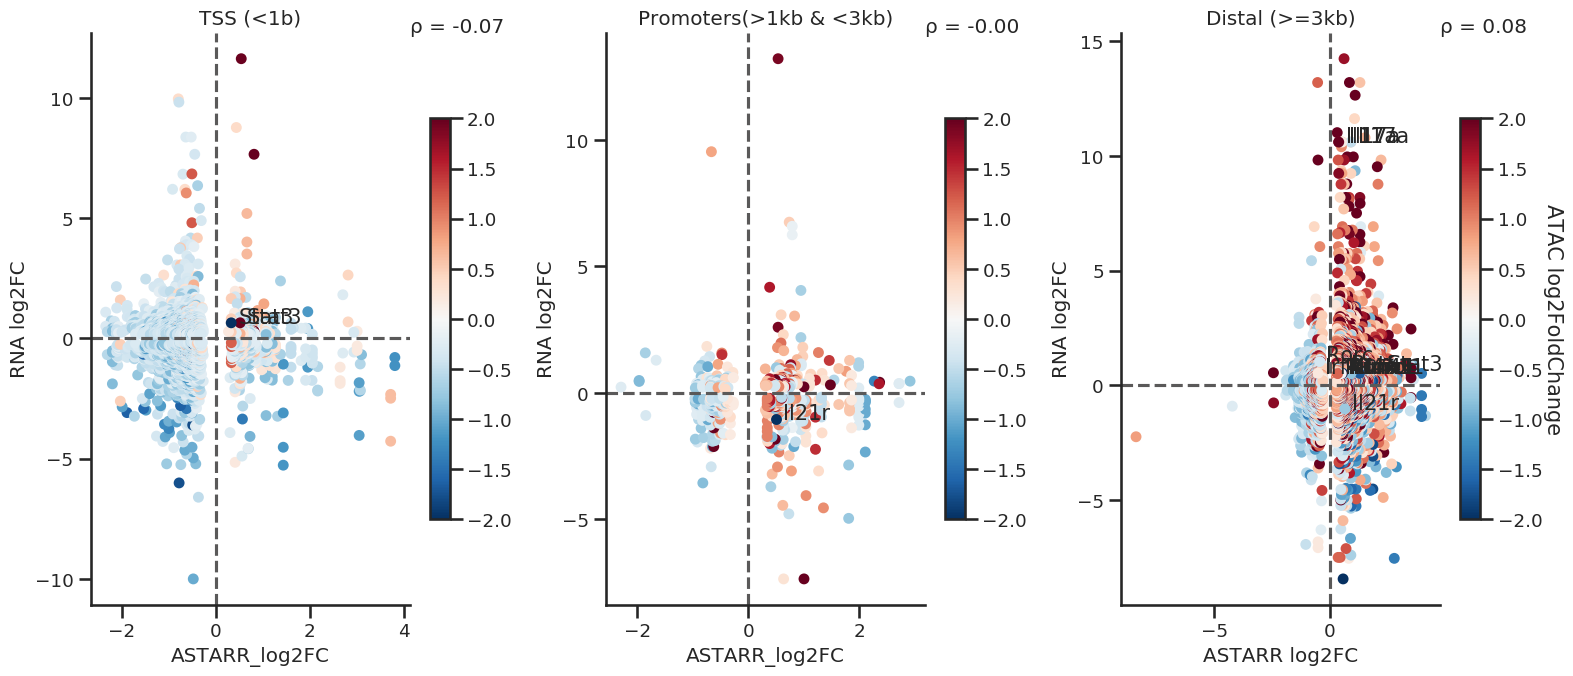

In [106]:
### Scatterplot for TSS(1b), promoter(>1kb&<3kb), distal(>=3kb) and all regions for ATACseq vs ASTARRseq

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
import numpy as np
%matplotlib inline

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt 

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1" # u'\u03C1'
    ax.annotate('%s = %.2f' % (rho, r), xy=(1, 1), xycoords=ax.transAxes)
    
#plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.8)
plt.rcParams.update({'figure.figsize':(16,7), 'figure.dpi':100})

fig, ax = plt.subplots(1, 3)

ax1 = ax.flatten()[0]
points = ax1.scatter(
    ASTARR_RNA_100kb_ATAC_intersected.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)<1, 'ASTARR_log2FoldChange'], 
    ASTARR_RNA_100kb_ATAC_intersected.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)<1, 'RNA_log2FoldChange'],
    c=ASTARR_RNA_100kb_ATAC_intersected.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)<1, 'ATAC_log2FoldChange'],
    cmap='RdBu_r', marker='o', s=40)

for x, y, t in zip(
    ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)<1, 'ASTARR_log2FoldChange'],
    ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)<1, 'RNA_log2FoldChange'], 
    ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)<1, 'GeneName']) :
    ax1.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)

ax1.scatter(
    ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)<1, 'ASTARR_log2FoldChange'], 
    ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)<1, 'RNA_log2FoldChange'],
    c=ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)<1, 'ATAC_log2FoldChange'],
    cmap='RdBu_r',marker='o', s=40)

corrfunc(
    ASTARR_RNA_100kb_ATAC_intersected.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)<1, 'ASTARR_log2FoldChange'], 
    ASTARR_RNA_100kb_ATAC_intersected.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)<1, 'RNA_log2FoldChange'],
    ax=ax1, method='spearman')

ax1.set_xlim(ax1.get_xlim())
ax1.set_ylim(ax1.get_ylim())
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color='#5A5959', linestyle='--')
ax1.hlines(0, ax1.get_xlim()[0], ax1.get_xlim()[1], color='#5A5959', linestyle='--')
ax1.set_xlabel('ASTARR_log2FC')
ax1.set_ylabel('RNA log2FC')
ax1.set_title('TSS (<1b)')

cbar = fig.colorbar(points, shrink=0.7, ax=ax1)
#cbar.set_label('ATAC log2FoldChange', rotation=270, fontsize=15, labelpad=15)
cbar.mappable.set_clim(-2,2)


ax2 = ax.flatten()[1]
points = ax2.scatter(
    ASTARR_RNA_100kb_ATAC_intersected.loc[(np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)>1000)&(np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)<3000), 'ASTARR_log2FoldChange'], 
    ASTARR_RNA_100kb_ATAC_intersected.loc[(np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)>1000)&(np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)<3000), 'RNA_log2FoldChange'],
    c=ASTARR_RNA_100kb_ATAC_intersected.loc[(np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)>1000)&(np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)<3000), 'ATAC_log2FoldChange'],
    cmap='RdBu_r', marker='o', s=40)

for x, y, t in zip(
    ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[(np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)>1000)&(np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)<3000), 'ASTARR_log2FoldChange'],
    ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[(np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)>1000)&(np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)<3000), 'RNA_log2FoldChange'], 
    ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[(np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)>1000)&(np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)<3000), 'GeneName']) :
    ax2.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)

ax2.scatter(
    ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[(np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)>1000)&(np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)<3000), 'ASTARR_log2FoldChange'], 
    ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[(np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)>1000)&(np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)<3000), 'RNA_log2FoldChange'], 
    c=ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[(np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)>1000)&(np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)<3000), 'ATAC_log2FoldChange'],
    cmap='RdBu_r',marker='o', s=40)

corrfunc(
    ASTARR_RNA_100kb_ATAC_intersected.loc[(np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)>1000)&(np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)<3000), 'ASTARR_log2FoldChange'], 
    ASTARR_RNA_100kb_ATAC_intersected.loc[(np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)>1000)&(np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)<3000), 'RNA_log2FoldChange'],
    ax=ax2, method='spearman')

ax2.set_xlim(ax2.get_xlim())
ax2.set_ylim(ax2.get_ylim())
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color='#5A5959', linestyle='--')
ax2.hlines(0, ax2.get_xlim()[0], ax2.get_xlim()[1], color='#5A5959', linestyle='--')
ax2.set_xlabel('ASTARR_log2FC')
ax2.set_ylabel('RNA log2FC')
ax2.set_title('Promoters(>1kb & <3kb)')

cbar = fig.colorbar(points, shrink=0.7, ax=ax2)
#cbar.set_label('ATAC log2FoldChange', rotation=270, fontsize=15, labelpad=15)
cbar.mappable.set_clim(-2,2)

ax3 = ax.flatten()[2]
points = ax3.scatter(
    ASTARR_RNA_100kb_ATAC_intersected.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)>=3000, 'ASTARR_log2FoldChange'], 
    ASTARR_RNA_100kb_ATAC_intersected.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)>=3000, 'RNA_log2FoldChange'],
    c=ASTARR_RNA_100kb_ATAC_intersected.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)>=3000, 'ATAC_log2FoldChange'],
    cmap='RdBu_r', marker='o', s=40)

for x, y, t in zip(
    ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)>=3000, 'ASTARR_log2FoldChange'],
    ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)>=3000, 'RNA_log2FoldChange'], 
    ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)>=3000, 'GeneName']) :
    ax3.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)
    
ax3.scatter(
    ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)>=3000, 'ASTARR_log2FoldChange'], 
    ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)>=3000, 'RNA_log2FoldChange'], 
    c=ASTARR_RNA_100kb_ATAC_intersected_spGenes.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected_spGenes.distance)>=3000, 'ATAC_log2FoldChange'], 
    cmap='RdBu_r', marker='o', s=40)

corrfunc(
    ASTARR_RNA_100kb_ATAC_intersected.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)>=3000, 'ASTARR_log2FoldChange'], 
    ASTARR_RNA_100kb_ATAC_intersected.loc[np.abs(ASTARR_RNA_100kb_ATAC_intersected.distance)>=3000, 'RNA_log2FoldChange'],
    ax=ax3, method='spearman')

ax3.set_xlim(ax3.get_xlim())
ax3.set_ylim(ax3.get_ylim())
ax3.vlines(0, ax3.get_ylim()[0], ax3.get_ylim()[1], color='#5A5959', linestyle='--')
ax3.hlines(0, ax3.get_xlim()[0], ax3.get_xlim()[1], color='#5A5959', linestyle='--')
ax3.set_xlabel('ASTARR log2FC')
ax3.set_ylabel('RNA log2FC')
ax3.set_title('Distal (>=3kb)')

cbar = fig.colorbar(points, shrink=0.7, ax=ax3)
cbar.set_label('ATAC log2FoldChange', rotation=270, fontsize=15, labelpad=15)
cbar.mappable.set_clim(-2,2)


# ax3 = ax.flatten()[2]
# points = ax3.scatter(
#     top_ATAC_not_ASTARR_with_genes_RNA.loc[:, 'ATAC_log2FoldChange'], 
#     top_ATAC_not_ASTARR_with_genes_RNA.loc[:, 'RNA_log2FoldChange'],
#     color='gray', marker='o', s=20, label='All hits')

# for x, y, t in zip(
#     top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[:, 'ATAC_log2FoldChange'],
#     top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[:, 'RNA_log2FoldChange'], 
#     top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[:, 'GeneName']) :
#     ax3.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)
    
# ax3.scatter(top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[:, 'ATAC_log2FoldChange'], 
#     top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[:, 'RNA_log2FoldChange'], marker='o', s=20, color='blue', label='Genes of Interest')
# corrfunc(
#     top_ATAC_not_ASTARR_with_genes_RNA.loc[:, 'ATAC_log2FoldChange'], 
#     top_ATAC_not_ASTARR_with_genes_RNA.loc[:, 'RNA_log2FoldChange'],
#     ax=ax3, method='spearman')

# ax3.set_xlim(ax3.get_xlim())
# ax3.set_ylim(ax3.get_ylim())
# ax3.vlines(0, ax3.get_ylim()[0], ax3.get_ylim()[1], color='#5A5959', linestyle='--')
# ax3.hlines(0, ax3.get_xlim()[0], ax3.get_xlim()[1], color='#5A5959', linestyle='--')
# ax3.set_xlabel('ATAC log2FC')
# ax3.set_ylabel('RNA log2FC')
# ax3.set_title('All Peaks')

# cbar = fig.colorbar(points)
# cbar.set_label('abs. distance to closest TSS', rotation=270)

sns.despine(fig,ax)
plt.tight_layout()
plt.savefig('/data/reddylab/Revathy/dev/Keith/data/integrative/plots/Th17_ASTARR_RNA_ATAC_TSS_promoter_distal_scatterplots.pdf')
plt.show()

In [43]:
def quadrant_annotation_STARR(df):
    if ((df['ASTARR_log2FoldChange'] < 0) and (df['RNA_log2FoldChange'] < 0)):
        return 'Dec.Regulatory peaks; Downreg DE genes'
    if ((df['ASTARR_log2FoldChange'] >= 0) and (df['RNA_log2FoldChange'] >= 0)):
        return 'Inc.Regulatory peaks; Upreg DE genes'
    if ((df['ASTARR_log2FoldChange'] < 0) and (df['RNA_log2FoldChange'] >= 0)):
        return 'Dec.Regulatory peaks; Upreg DE genes'
    if ((df['ASTARR_log2FoldChange'] >= 0) and (df['RNA_log2FoldChange'] < 0)):
        return 'Inc.Regulatory peaks; Downreg DE genes'
    

ASTARR_RNA_100kb_ATAC_intersected['Quadrant_annot'] = ASTARR_RNA_100kb_ATAC_intersected.apply(quadrant_annotation_STARR, axis=1)
ASTARR_RNA_100kb_ATAC_intersected.to_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_ATAC_100kb_annotated.bed', sep='\t', index=None, header=None)
ASTARR_RNA_100kb_ATAC_intersected.head(5)


,chr,start,end,chr_start_end,ASTARR_log2FoldChange,RNA_log2FoldChange,GeneName,|log2FC|,distance,ATAC_log2FoldChange,ATAC_padj,Quadrant_annot
0,chr17,79715094,79716097,chr17_79715094_79716097,1.607470,14.246579,Cyp1b1,15.854049,-537,1.162663,1.538158e-30,Inc.Regulatory peaks; Upreg DE genes
1,chr17,79614709,79615534,chr17_79614709_79615534,-0.739119,14.246579,Cyp1b1,14.985698,-88,-0.500127,1.260159e-04,Dec.Regulatory peaks; Upreg DE genes
2,chr17,79755008,79755331,chr17_79755008_79755331,0.620197,14.246579,Cyp1b1,14.866776,-39968,1.721831,1.198963e-16,Inc.Regulatory peaks; Upreg DE genes
3,chr3,37172936,37173736,chr3_37172936_37173736,1.310077,13.208127,Il21,14.518204,-47211,0.581702,1.496742e-21,Inc.Regulatory peaks; Upreg DE genes
4,chr3,37213303,37213537,chr3_37213303_37213537,0.853785,13.208127,Il21,14.061913,18963,2.948243,1.247789e-41,Inc.Regulatory peaks; Upreg DE genes


In [44]:
%%bash 
module load bedtools2
cd /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data
bedtools subtract \
-a Th17_ASTARR_RNA_100kb_genes.bed \
-b Th17_ASTARR_RNA_ATAC_100kb_annotated.bed \
> /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_not_in_ATAC_100kb.txt

In [48]:
!wc -l /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_not_in_ATAC_100kb.txt

7821 /data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_not_in_ATAC_100kb.txt


In [46]:
import pandas as pd

ASTARR_RNA_not_in_ATAC = pd.read_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_ASTARR_RNA_not_in_ATAC_100kb.txt', sep='\t',
                                     names=['chr','start','end','chr_start_end','ASTARR_log2FoldChange','RNA_log2FoldChange','GeneName','|log2FC|'])

ASTARR_RNA_not_in_ATAC.drop(columns='chr_start_end', inplace=False)
ASTARR_RNA_not_in_ATAC.sort_values(by='|log2FC|', ascending=False, inplace=False)
ASTARR_RNA_not_in_ATAC['Quadrant_annot'] = ASTARR_RNA_not_in_ATAC.apply(quadrant_annotation_STARR, axis=1)
#ASTARR_RNA_not_in_ATAC = ASTARR_RNA_not_in_ATAC.drop(columns = 'chr_start_end')
ASTARR_RNA_not_in_ATAC.head(5)


,chr,start,end,chr_start_end,ASTARR_log2FoldChange,RNA_log2FoldChange,GeneName,|log2FC|,Quadrant_annot
0,chr3,37213537,37213655,chr3_37213347_37213655,0.853785,13.208127,Il21,14.061913,Inc.Regulatory peaks; Upreg DE genes
1,chr13,56601818,56601855,chr13_56601201_56601855,1.101679,12.653597,Tgfbi,13.755275,Inc.Regulatory peaks; Upreg DE genes
2,chr3,37231407,37231589,chr3_37231354_37231589,0.536181,13.208127,Il21,13.744309,Inc.Regulatory peaks; Upreg DE genes
3,chr3,37313407,37313912,chr3_37313407_37313912,0.503811,13.208127,Il21,13.711939,Inc.Regulatory peaks; Upreg DE genes
4,chr13,56522190,56522726,chr13_56522190_56522726,-0.501968,12.653597,Tgfbi,13.155565,Dec.Regulatory peaks; Upreg DE genes


In [49]:
len(ASTARR_RNA_not_in_ATAC.chr_start_end.unique())

3286

In [47]:
regASTARR_deRNA_ATAC = pd.concat([ASTARR_RNA_100kb_ATAC_intersected,ASTARR_RNA_not_in_ATAC], ignore_index=True, sort=False)
regASTARR_deRNA_ATAC.to_csv('/data/reddylab/Revathy/dev/Keith/data/integrative/tmp_data/Th17_regASTARR_deRNA_applicableATAC_with_pvalue.txt', sep='\t')
regASTARR_deRNA_ATAC

,chr,start,end,chr_start_end,ASTARR_log2FoldChange,RNA_log2FoldChange,GeneName,|log2FC|,distance,ATAC_log2FoldChange,ATAC_padj,Quadrant_annot
0,chr17,79715094,79716097,chr17_79715094_79716097,1.607470,14.246579,Cyp1b1,15.854049,-537.0,1.162663,1.538158e-30,Inc.Regulatory peaks; Upreg DE genes
1,chr17,79614709,79615534,chr17_79614709_79615534,-0.739119,14.246579,Cyp1b1,14.985698,-88.0,-0.500127,1.260159e-04,Dec.Regulatory peaks; Upreg DE genes
2,chr17,79755008,79755331,chr17_79755008_79755331,0.620197,14.246579,Cyp1b1,14.866776,-39968.0,1.721831,1.198963e-16,Inc.Regulatory peaks; Upreg DE genes
3,chr3,37172936,37173736,chr3_37172936_37173736,1.310077,13.208127,Il21,14.518204,-47211.0,0.581702,1.496742e-21,Inc.Regulatory peaks; Upreg DE genes
4,chr3,37213303,37213537,chr3_37213303_37213537,0.853785,13.208127,Il21,14.061913,18963.0,2.948243,1.247789e-41,Inc.Regulatory peaks; Upreg DE genes
5,chr13,56601201,56601818,chr13_56601201_56601818,1.101679,12.653597,Tgfbi,13.755275,7730.0,4.370301,3.371766e-49,Inc.Regulatory peaks; Upreg DE genes
6,chr3,37231146,37231407,chr3_37231146_37231407,0.536181,13.208127,Il21,13.744309,1029.0,1.896756,7.480841e-44,Inc.Regulatory peaks; Upreg DE genes
7,chr3,37218953,37219529,chr3_37218953_37219529,-0.524473,13.208127,Il21,13.732600,13089.0,1.194538,1.906962e-26,Dec.Regulatory peaks; Upreg DE genes
8,chr6,67415045,67415600,chr6_67415045_67415600,1.075140,11.632752,Il23r,12.707893,-39197.0,0.418952,2.156423e-03,Inc.Regulatory peaks; Upreg DE genes
9,chr1,83076076,83077470,chr1_83076076_83077470,1.529116,10.800780,Ccl20,12.329896,-15819.0,0.716061,1.433909e-05,Inc.Regulatory peaks; Upreg DE genes


### Venn Digram for the new ASTARR hits

In [1]:
!head /data/reddylab/Keith/encode4_duke/analysis/210530_Th17ASTARRseq_analysis/210531_Th17ASTARR_deseq2_topHits.padj0.01.txt

chr start end baseMean log2FoldChange lfcSE stat pvalue padj
chr1 100180104 100180427 1773.53264664614 -0.655964765633773 0.122235338428588 -5.36640855309611 8.0319893788566e-08 1.20851329412271e-06
chr1 10039113 10040507 569.293036318009 -0.99333440319473 0.127101708982002 -7.81527180988093 5.48445498368799e-15 1.89956406337699e-13
chr1 101902172 101903346 150.909441360634 1.76938192379772 0.244219899813798 7.24503582691976 4.32324910205424e-13 1.22637060692738e-11
chr1 10231618 10233764 446.837134535862 -0.967103437688299 0.132499761383107 -7.29890701381743 2.90114721215753e-13 8.41100212283308e-12
chr1 105395811 105396518 441.176075656751 0.461614811471641 0.131088808683109 3.52138993487643 0.000429290839473043 0.00326579226233431
chr1 105431762 105432508 440.953978599798 0.777306141879019 0.17263948243781 4.50248188249192 6.71644820166419e-06 7.37755741680839e-05
chr1 105442168 105443842 175.039780450404 1.18415839908875 0.210645460017931 5.62157095143635 1.89228751127501e-08 3.118

In [20]:
import pandas as pd

Th17_ASTARR = pd.read_csv('/data/reddylab/Keith/encode4_duke/analysis/210530_Th17ASTARRseq_analysis/210531_Th17ASTARR_deseq2_topHits.padj0.01.txt', sep='\t')
colnames = Th17_ASTARR.columns.tolist()[0].split(' ')
Th17_ASTARR[colnames] = Th17_ASTARR['chr start end baseMean log2FoldChange lfcSE stat pvalue padj'].str.split(' ', expand=True)
Th17_ASTARR.drop(columns = ['chr start end baseMean log2FoldChange lfcSE stat pvalue padj'], inplace=True)
Th17_ASTARR['chr_start_end'] = Th17_ASTARR['chr'] + '_' + Th17_ASTARR['start'] + '_' + Th17_ASTARR['end']
Th17_ASTARR = Th17_ASTARR.drop(columns='stat')
# Th17_ASTARR = Th17_ASTARR[['chr','start','end']]
Th17_ASTARR.to_csv('/data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ASTARR_hits_new.bed', sep='\t', index=False, header=False)
Th17_ASTARR.to_csv('/data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ASTARR_hits_new.txt', sep='\t', index=False)
Th17_ASTARR.head(10)

,chr,start,end,baseMean,log2FoldChange,lfcSE,pvalue,padj,chr_start_end
0,chr1,100180104,100180427,1773.53264664614,-0.655964765633773,0.122235338428588,8.0319893788566e-08,1.20851329412271e-06,chr1_100180104_100180427
1,chr1,10039113,10040507,569.293036318009,-0.99333440319473,0.127101708982002,5.48445498368799e-15,1.89956406337699e-13,chr1_10039113_10040507
2,chr1,101902172,101903346,150.909441360634,1.76938192379772,0.244219899813798,4.32324910205424e-13,1.22637060692738e-11,chr1_101902172_101903346
3,chr1,10231618,10233764,446.837134535862,-0.967103437688299,0.132499761383107,2.90114721215753e-13,8.41100212283308e-12,chr1_10231618_10233764
4,chr1,105395811,105396518,441.176075656751,0.461614811471641,0.131088808683109,0.000429290839473043,0.00326579226233431,chr1_105395811_105396518
5,chr1,105431762,105432508,440.953978599798,0.777306141879019,0.17263948243781,6.71644820166419e-06,7.37755741680839e-05,chr1_105431762_105432508
6,chr1,105442168,105443842,175.039780450404,1.18415839908875,0.210645460017931,1.89228751127501e-08,3.11841368175214e-07,chr1_105442168_105443842
7,chr1,105527645,105528886,256.858219449036,0.729382724267084,0.165734944142875,1.07803375366221e-05,0.00011421028411938,chr1_105527645_105528886
8,chr1,105564604,105565424,1055.07239354963,0.73734605773208,0.136853384824897,7.13039341700849e-08,1.0807107536957e-06,chr1_105564604_105565424
9,chr1,105780126,105782053,141.962720105408,-0.773380501476652,0.231072937315022,0.000817175110170748,0.00578950163113872,chr1_105780126_105782053


In [10]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
module load gcc
export PYTHONPATH="/data/reddylab/projects/GGR/analyses/group_general/top_level_scripts/GGR:${PYTHONPATH}"
python /data/reddylab/Alex/reddylab_utils/scripts/plot_overlap_as_venn_diagram.py \
  -i /data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ASTARR_hits_new.bed /data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ATAC_hits.bed \
  --names ASTARR ATACseq \
  -o /data/reddylab/Revathy/collabs/Keith/data/integrative/plots/ASTARR_new_vs_ATAChits.png /data/reddylab/Revathy/collabs/Keith/data/integrative/plots/ASTARR_new_vs_ATAChits.pdf \
  --bed 

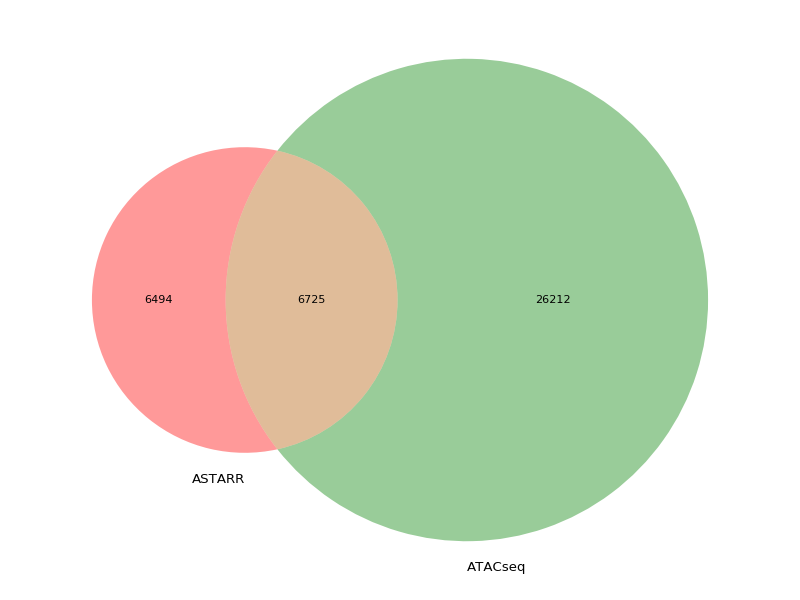

In [11]:
from IPython.display import display,Image
display(Image('/data/reddylab/Revathy/collabs/Keith/data/integrative/plots/ASTARR_new_vs_ATAChits.png'))
    

### Intersection of ASTARR peaks (new hits) and ATAC peaks

In [28]:
%%bash
module load bedtools2
bedtools intersect \
-a /data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ASTARR_hits_new.bed \
-b /data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ATAC_hits.bed \
-wa \
-wb \
> /data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ASTARR_new_vs_ATAC_hits_intersect.txt


***** WARNING: File /data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ATAC_hits.bed has inconsistent naming convention for record:
JH584304.1	58860	61077	5823.345871634089	-0.6417921415048189	0.102590550555126	1.74725644456278e-10	1.00153216726169e-09	JH584304.1_58860_61077

***** WARNING: File /data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ATAC_hits.bed has inconsistent naming convention for record:
JH584304.1	58860	61077	5823.345871634089	-0.6417921415048189	0.102590550555126	1.74725644456278e-10	1.00153216726169e-09	JH584304.1_58860_61077



In [34]:
!wc -l /data/reddylab/Keith/encode4_duke/analysis/210530_Th17ASTARRseq_analysis/210531_Th17ASTARR_deseq2_topHits.padj0.01.txt

13220 /data/reddylab/Keith/encode4_duke/analysis/210530_Th17ASTARRseq_analysis/210531_Th17ASTARR_deseq2_topHits.padj0.01.txt


In [30]:
%%bash
cat /data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ASTARR_new_vs_ATAC_hits_intersect.txt \
| awk -vOFS='\t' '{print $1, $2<$11?$2:$11, $3<$12?$3:$12, $0}' > /data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ASTARR_new_vs_ATAC_hits_intersect_filtered.txt


In [21]:
ATAC_hits = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ATAC_hits.txt', sep='\t')
ATAC_hits.head(10)
headers = ATAC_hits.columns.tolist()
ASTARR_headers = ["ASTARR_" + h for h in headers]
ATAC_headers = ["ATAC_" + h for h in headers]

In [33]:
import pandas as pd

ASTARR_new_ATAC = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ASTARR_new_vs_ATAC_hits_intersect_filtered.txt', sep='\t', index_col=False, header=None, names=['chr','start','end']+ASTARR_headers+ATAC_headers)

# ASTARR_ATAC = ASTARR_ATAC.astype(str)
# ASTARR_ATAC['chr_start_end'] = ASTARR_ATAC['chr'] + '_' + ASTARR_ATAC['start'] + '_' + ASTARR_ATAC['end']
# ASTARR_ATAC['ASTARR_diff'] = ASTARR_ATAC['ASTARR_end']-ASTARR_ATAC['ASTARR_start']
# ASTARR_ATAC['ATAC_diff'] = ASTARR_ATAC['ATAC_end']-ASTARR_ATAC['ATAC_start']
# #ASTARR_ATAC['chr_start_end]
            
# def diff_select(a, b):
#     if a_diff >= b_diff:
#         chr_start_end = a_chr_start_end
#     else:
#         chr_start_end = b_chr_start_end


# ASTARR_new_ATAC['chr_start_end'] = ASTARR_new_ATAC['chr'] + '_' + ASTARR_new_ATAC['start'].astype(str) + '_' + ASTARR_new_ATAC['end'].astype(str)
ASTARR_new_ATAC_subset = ASTARR_new_ATAC[['chr_start_end','ASTARR_log2FoldChange','ATAC_log2FoldChange']]           
ASTARR_new_ATAC.head(10)

ASTARR_ATAC_subset.to_csv('/data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ASTARR_ATAC_subset.txt', sep='\t', index=False, header=False)
ASTARR_ATAC_subset.to_csv('/data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ASTARR_ATAC_subset.bed', sep='\t', index=False, header=False)


,chr,start,end,ASTARR_chr,ASTARR_start,ASTARR_end,ASTARR_baseMean,ASTARR_log2FoldChange,ASTARR_lfcSE,ASTARR_pvalue,...,ASTARR_chr_start_end,ATAC_chr,ATAC_start,ATAC_end,ATAC_baseMean,ATAC_log2FoldChange,ATAC_lfcSE,ATAC_pvalue,ATAC_padj,ATAC_chr_start_end
0,chr1,100180104,100180396,chr1,100180104,100180427,1773.532647,-0.655965,0.122235,8.031989e-08,...,chr1_100180104_100180427,chr1,100180106,100180396,1204.794942,0.661353,0.079748,4.804716e-17,4.909863e-16,chr1_100180106_100180396
1,chr1,10231604,10233735,chr1,10231618,10233764,446.837135,-0.967103,0.132500,2.901147e-13,...,chr1_10231618_10233764,chr1,10231604,10233735,530.579071,-0.468434,0.094681,4.299113e-07,1.669141e-06,chr1_10231604_10233735
2,chr1,105564604,105565356,chr1,105564604,105565424,1055.072394,0.737346,0.136853,7.130393e-08,...,chr1_105564604_105565424,chr1,105564727,105565356,499.124911,1.085155,0.109778,6.745829e-24,1.108137e-22,chr1_105564727_105565356
3,chr1,105780126,105781353,chr1,105780126,105782053,141.962720,-0.773381,0.231073,8.171751e-04,...,chr1_105780126_105782053,chr1,105780263,105781353,124.126095,-0.663113,0.171150,4.297943e-05,1.241390e-04,chr1_105780263_105781353
4,chr1,105971475,105972526,chr1,105971475,105972577,329.373188,2.629590,0.482831,5.146110e-08,...,chr1_105971475_105972577,chr1,105971611,105972526,114.584245,-1.274385,0.178303,7.376010e-14,5.807037e-13,chr1_105971611_105972526
5,chr1,106127503,106128051,chr1,106127503,106128307,425.825884,0.716544,0.133260,7.572646e-08,...,chr1_106127503_106128307,chr1,106127818,106128051,203.578695,2.910621,0.195208,7.367235e-52,4.666598e-50,chr1_106127818_106128051
6,chr1,106171157,106173071,chr1,106171157,106173071,858.142331,-0.614498,0.102399,1.961195e-09,...,chr1_106171157_106173071,chr1,106171171,106173252,944.593482,-0.557370,0.069535,5.603331e-16,5.276263e-15,chr1_106171171_106173252
7,chr1,106320688,106321976,chr1,106320688,106322076,911.847581,1.584776,0.118679,1.131458e-40,...,chr1_106320688_106322076,chr1,106320698,106321976,515.564944,-0.498415,0.092079,3.400050e-08,1.519481e-07,chr1_106320698_106321976
8,chr1,106352639,106353539,chr1,106352639,106353544,277.742837,0.572343,0.165824,5.574675e-04,...,chr1_106352639_106353544,chr1,106352639,106353539,272.663548,-0.478354,0.130418,1.369145e-04,3.627508e-04,chr1_106352639_106353539
9,chr1,106374021,106375674,chr1,106374021,106375674,421.468457,0.792856,0.136374,6.105323e-09,...,chr1_106374021_106375674,chr1,106374147,106376322,402.325943,-1.064157,0.109139,2.734639e-23,4.312279e-22,chr1_106374147_106376322


### Co-ordinate plots for RNAseq vs ATACseq without the STARR component but split into Promoters, Distal and all peaks

In [11]:
import pandas as pd

ATAC_hits = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ATAC_hits.bed', sep='\t', names=['chr','start','end','baseMean','log2FoldChange','lfcSE','pvalue','padj','chr_start_end'])
RNA_genes = pd.read_csv('/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes_padjFiltered0.01.txt', sep='\t')
RNA_genes = RNA_genes.rename(columns = {'Unnamed: 0.1':'ENS_ID'})
RNA_genes = RNA_genes.drop(columns='Unnamed: 0')


ATAC_hits = ATAC_hits[ATAC_hits['padj']<0.01]
ATAC_hits[['chr','start','end']] = ATAC_hits['chr_start_end'].str.split('_', expand=True)
ATAC_hits = ATAC_hits[['chr','start','end','log2FoldChange','padj','chr_start_end']]
ATAC_hits.to_csv('/data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ATAC_significant_hits_subset.bed', sep='\t', header=None, index=False)


In [7]:
!head /data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ATAC_significant_hits_subset.bed

chr4_143288226_143289757	3.81726459784635	1.5487564275631893e-140
chr16_25010772_25012159	3.4847272376130403	1.436014074133259e-132
chr2_181099140_181100692	2.9614912246334	5.009012092561448e-128
chr17_24922152_24923413	4.0565278670521305	1.0672507887332194e-117
chr6_88827500_88829063	3.5313398299055696	5.464938410178948e-115
chr1_36965264_36966375	2.32734236110937	1.4148962301397491e-111
chr12_70890543_70891870	3.98211754387464	7.478414170106755e-108
chr1_93529464_93530987	3.19374550045465	2.9481488759608596e-106
chr13_49396570_49397505	3.1995712004824	2.7440142581850596e-105
chr17_44707603_44708909	3.943733258178721	2.87376076381525e-101


In [5]:
import pandas as pd

vM19_gencode_annotation = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/data/gencode.vM19.basic.annotation.TSS.bed', sep='\t', names=['chr','start','end','ENS_ID','score','strand','GeneName','GeneType'])
RNA_DE_genes_annotated = RNA_genes.merge(vM19_gencode_annotation, on='ENS_ID', how='inner')
RNA_DE_genes_annotated = RNA_DE_genes_annotated.rename(columns={'GeneName_x':'GeneName',
                                                                'GeneType_x':'GeneType'})
RNA_DE_genes_annotated = RNA_DE_genes_annotated[['chr','start','end','ENS_ID','score','strand','GeneName','GeneType','log2FoldChange','padj']]
RNA_DE_genes_annotated.to_csv('/data/reddylab/Revathy/collabs/Keith/data/Th17.72hr_vs_Th0.DE_genes.annotation.TSS.bed', sep='\t', header=None, index=False)
RNA_DE_genes_annotated

,chr,start,end,ENS_ID,score,strand,GeneName,GeneType,log2FoldChange,padj
0,chr1,20730903,20730904,ENSMUSG00000025929.4,.,+,Il17a,protein_coding,10.610688,0.000000
1,chr1,20784269,20784270,ENSMUSG00000041872.9,.,-,Il17f,protein_coding,9.242296,0.000000
2,chr1,40225078,40225079,ENSMUSG00000026072.12,.,+,Il1r1,protein_coding,6.603334,0.000000
3,chr1,83116764,83116765,ENSMUSG00000026166.14,.,+,Ccl20,protein_coding,10.800780,0.000000
4,chr1,133801040,133801041,ENSMUSG00000026463.17,.,-,Atp2b4,protein_coding,3.365006,0.000000
5,chr1,171917513,171917514,ENSMUSG00000015314.10,.,+,Slamf6,protein_coding,-5.925895,0.000000
6,chr1,176814066,176814067,ENSMUSG00000057335.11,.,-,Cep170,protein_coding,2.677110,0.000000
7,chr2,11642805,11642806,ENSMUSG00000026770.5,.,+,Il2ra,protein_coding,1.791230,0.000000
8,chr4,4138476,4138477,ENSMUSG00000045573.9,.,-,Penk,protein_coding,-5.445746,0.000000
9,chr4,43957399,43957400,ENSMUSG00000028480.14,.,+,Glipr2,protein_coding,1.953312,0.000000


In [33]:
%%bash
cd /data/reddylab/Revathy/collabs/Keith/data/integrative/
sbatch -p all \
    --cpus-per-task 1 \
    --mem 8G \
    -o /data/reddylab/Revathy/collabs/Keith/data/integrative/logs/Th17.72hr_vs_Th0.DE_genes_annotation.out \
    <<'EOF'
#!/bin/bash
SAMPLE="Th17_ATAC_significant_hits_subset.bed"

tail -n+2 ${SAMPLE} \
| cut -f1 \
| awk -F_ -vOFS="\t" '{print $1, $2, $3, $1"_"$2"_"$3}' \
| sort -k1,1 -k2,2n \
| bedtools closest \
    -nonamecheck \
    -D a \
    -a - \
    -b /data/reddylab/Revathy/collabs/Keith/data/gencode.vM19.basic.annotation.TSS.bed \
| awk -vOFS="\t" \
    '{if(last==$4){genes=$11","genes;}else{if(genes){print peak, genes, distance}peak=$4; genes=$11; distance=$13; last=peak}}END{if(last==$4){genes=$11","genes;print peak, genes, distance}}' \
> ${SAMPLE/.bed/.closest_gene.txt}

EOF

Submitted batch job 25787585


In [1]:
!head /data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ATAC_significant_hits_subset.bed


chr4	143288226	143289757	3.81726459784635	1.5487564275631893e-140	chr4_143288226_143289757
chr16	25010772	25012159	3.4847272376130403	1.436014074133259e-132	chr16_25010772_25012159
chr2	181099140	181100692	2.9614912246334	5.009012092561448e-128	chr2_181099140_181100692
chr17	24922152	24923413	4.0565278670521305	1.0672507887332194e-117	chr17_24922152_24923413
chr6	88827500	88829063	3.5313398299055696	5.464938410178948e-115	chr6_88827500_88829063
chr1	36965264	36966375	2.32734236110937	1.4148962301397491e-111	chr1_36965264_36966375
chr12	70890543	70891870	3.98211754387464	7.478414170106755e-108	chr12_70890543_70891870
chr1	93529464	93530987	3.19374550045465	2.9481488759608596e-106	chr1_93529464_93530987
chr13	49396570	49397505	3.1995712004824	2.7440142581850596e-105	chr13_49396570_49397505
chr17	44707603	44708909	3.943733258178721	2.87376076381525e-101	chr17_44707603_44708909


In [8]:
import pandas as pd

Th17_ATAC_sig_hits_closest_gene = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/data/integrative/Th17_ATAC_significant_hits_subset.closest_gene.txt', sep='\t', names=['chr_start_end','GeneName','distance'])
Th17_sig_ATAC_gene_log2FC = Th17_ATAC_sig_hits_closest_gene.merge(ATAC_hits, on='chr_start_end', how='inner')
Th17_sig_ATAC_gene_log2FC


,chr_start_end,GeneName,distance,log2FoldChange,padj
0,chr1_4600559_4601117,Sox17,-103206,2.162068,2.596728e-12
1,chr1_4671564_4672001,Mrpl15,113738,-1.304093,8.217621e-05
2,chr1_4888157_4888775,Tcea1,-30345,1.202951,3.625168e-03
3,chr1_5015194_5015905,Atp6v1h,54112,1.431848,1.979243e-15
4,chr1_5031597_5031970,Atp6v1h,38047,1.315686,4.026239e-05
5,chr1_5082592_5083621,Rgs20,-12308,0.516028,1.541110e-03
6,chr1_6382605_6383624,Alkal1,-23389,-1.052273,1.807543e-05
7,chr1_6441071_6441745,St18,45485,-0.994595,5.586058e-03
8,chr1_7138418_7138810,Pcmtd1,-49500,1.312680,4.524718e-03
9,chr1_7173897_7174659,Pcmtd1,-84979,2.071236,1.612835e-09


In [16]:
import pandas as pd

Th17_ATAC_sig_hits_100kb_DE_gene_annot = pd.read_csv('/data/reddylab/Revathy/collabs/Keith/data/integrative/tmp_data/Th17_ATAC_significant_hits_100kb_genes.txt', sep='\t', 
                                                     names=['chr','start','end','baseMean','ATAC_log2FC','lfcSE','pvalue','ATAC_padj','chr_start_end','rna_chr','rna_start','rna_end','ENS_ID','score','strand','GeneName','GeneType','RNA_log2FC','RNA_padj'])

Th17_ATAC_sig_hits_100kb_DE_gene_annot = Th17_ATAC_sig_hits_100kb_DE_gene_annot[['chr','start','end','GeneName','ATAC_log2FC','ATAC_padj','RNA_log2FC','RNA_padj']]
Th17_ATAC_sig_hits_100kb_DE_gene_annot.to_csv('/data/reddylab/Revathy/collabs/Keith/data/integrative/tmp_data/Th17_ATAC_significant_hits_100kb_genes_subset.bed', sep='\t', header=None, index=False)
Th17_ATAC_sig_hits_100kb_DE_gene_annot


,chr,start,end,GeneName,ATAC_log2FC,ATAC_padj,RNA_log2FC,RNA_padj
0,chr4,143288226,143289757,Pdpn,3.817265,1.548756e-140,11.022171,3.640139e-67
1,chr2,181099140,181100692,Ppdpf,2.961491,5.009012e-128,-0.590790,2.007072e-15
2,chr17,24922152,24923413,Hagh,4.056528,1.067251e-117,-0.549224,1.321711e-06
3,chr17,24922152,24923413,Fahd1,4.056528,1.067251e-117,-0.724632,2.265281e-04
4,chr17,24922152,24923413,Nubp2,4.056528,1.067251e-117,0.224277,9.410034e-03
5,chr17,24922152,24923413,Eme2,4.056528,1.067251e-117,-0.822810,1.851290e-16
6,chr17,24922152,24923413,Mrps34,4.056528,1.067251e-117,-0.420449,1.021210e-07
7,chr17,24922152,24923413,Mapk8ip3,4.056528,1.067251e-117,-0.589345,1.842025e-09
8,chr6,88827500,88829063,Mcm2,3.531340,5.464938e-115,0.227990,5.242240e-04
9,chr6,88827500,88829063,Tpra1,3.531340,5.464938e-115,-1.187749,4.818412e-15


In [ ]:
### Scatterplot for promoter(<3kb), distal(>=3kb) and all regions for ATACseq vs ASTARRseq

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
import numpy as np
%matplotlib inline

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt 

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1" # u'\u03C1'
    ax.annotate('%s = %.2f' % (rho, r), xy=(1, 1), xycoords=ax.transAxes)
    
#plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=1)
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':100})

fig, ax = plt.subplots(1, 3, figsize=(18,10))

ax1 = ax.flatten()[0]
points = ax1.scatter(
    Th17_ATAC_sig_hits_100kb_DE_gene_annot.loc[np.abs(Th17_ATAC_sig_hits_100kb_DE_gene_annot.distance)<3000, 'ATAC_log2FoldChange'], 
    top_ATAC_not_ASTARR_with_genes_RNA.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA.distance)<3000, 'RNA_log2FoldChange'],
    color='gray', marker='o', s=20, label='All hits')

for x, y, t in zip(
    top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA_spGenes.distance)<3000, 'ATAC_log2FoldChange'],
    top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA_spGenes.distance)<3000, 'RNA_log2FoldChange'], 
    top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA_spGenes.distance)<3000, 'GeneName']) :
    ax1.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)

ax1.scatter(top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA_spGenes.distance)<3000, 'ATAC_log2FoldChange'], 
    top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA_spGenes.distance)<3000, 'RNA_log2FoldChange'], marker='o', s=20, color='blue', label='Genes of Interest')

corrfunc(
    top_ATAC_not_ASTARR_with_genes_RNA.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA.distance)<3000, 'ATAC_log2FoldChange'], 
    top_ATAC_not_ASTARR_with_genes_RNA.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA.distance)<3000, 'RNA_log2FoldChange'],
    ax=ax1, method='spearman')

ax1.set_xlim(ax1.get_xlim())
ax1.set_ylim(ax1.get_ylim())
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color='#5A5959', linestyle='--')
ax1.hlines(0, ax1.get_xlim()[0], ax1.get_xlim()[1], color='#5A5959', linestyle='--')
ax1.set_xlabel('ATAC_log2FC')
ax1.set_ylabel('RNA log2FC')
ax1.set_title('Promoters (<3kb)')


ax2 = ax.flatten()[1]
points = ax2.scatter(
    top_ATAC_not_ASTARR_with_genes_RNA.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA.distance)>=3000, 'ATAC_log2FoldChange'], 
    top_ATAC_not_ASTARR_with_genes_RNA.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA.distance)>=3000, 'RNA_log2FoldChange'],
    color='gray', marker='o', s=20, label='All hits')

for x, y, t in zip(
    top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA_spGenes.distance)>=3000, 'ATAC_log2FoldChange'],
    top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA_spGenes.distance)>=3000, 'RNA_log2FoldChange'], 
    top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA_spGenes.distance)>=3000, 'GeneName']) :
    ax2.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)
    
ax2.scatter(top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA_spGenes.distance)>=3000, 'ATAC_log2FoldChange'], 
    top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA_spGenes.distance)>=3000, 'RNA_log2FoldChange'], marker='o', s=20, color='blue', label='Genes of Interest')
corrfunc(
    top_ATAC_not_ASTARR_with_genes_RNA.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA.distance)>=3000, 'ATAC_log2FoldChange'], 
    top_ATAC_not_ASTARR_with_genes_RNA.loc[np.abs(top_ATAC_not_ASTARR_with_genes_RNA.distance)>=3000, 'RNA_log2FoldChange'],
    ax=ax2, method='spearman')

ax2.set_xlim(ax2.get_xlim())
ax2.set_ylim(ax2.get_ylim())
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color='#5A5959', linestyle='--')
ax2.hlines(0, ax2.get_xlim()[0], ax2.get_xlim()[1], color='#5A5959', linestyle='--')
ax2.set_xlabel('ATAC log2FC')
ax2.set_ylabel('RNA log2FC')
ax2.set_title('Distal (>=3kb)')


ax3 = ax.flatten()[2]
points = ax3.scatter(
    top_ATAC_not_ASTARR_with_genes_RNA.loc[:, 'ATAC_log2FoldChange'], 
    top_ATAC_not_ASTARR_with_genes_RNA.loc[:, 'RNA_log2FoldChange'],
    color='gray', marker='o', s=20, label='All hits')

for x, y, t in zip(
    top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[:, 'ATAC_log2FoldChange'],
    top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[:, 'RNA_log2FoldChange'], 
    top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[:, 'GeneName']) :
    ax3.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left', textcoords='offset points', fontsize=15)
    
ax3.scatter(top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[:, 'ATAC_log2FoldChange'], 
    top_ATAC_not_ASTARR_with_genes_RNA_spGenes.loc[:, 'RNA_log2FoldChange'], marker='o', s=20, color='blue', label='Genes of Interest')
corrfunc(
    top_ATAC_not_ASTARR_with_genes_RNA.loc[:, 'ATAC_log2FoldChange'], 
    top_ATAC_not_ASTARR_with_genes_RNA.loc[:, 'RNA_log2FoldChange'],
    ax=ax3, method='spearman')

ax3.set_xlim(ax3.get_xlim())
ax3.set_ylim(ax3.get_ylim())
ax3.vlines(0, ax3.get_ylim()[0], ax3.get_ylim()[1], color='#5A5959', linestyle='--')
ax3.hlines(0, ax3.get_xlim()[0], ax3.get_xlim()[1], color='#5A5959', linestyle='--')
ax3.set_xlabel('ATAC log2FC')
ax3.set_ylabel('RNA log2FC')
ax3.set_title('All Peaks')

# cbar = fig.colorbar(points)
# cbar.set_label('abs. distance to closest TSS', rotation=270)

sns.despine(fig,ax)
plt.tight_layout()
plt.show()